# Exploration of CommScores metrics using the Arabidopsis leaf microbiome

In this notebook we explore the applicability of CommScores metrics for predicting interactions in microbial co-cultures.
We explore experimental datasets from a study of the Arabidopsis (AT)leaf microbiome[[1]](#1).

<a id="1">[1]</a>: Schäfer, M., Pacheco, A. R., Künzler, R., Bortfeld-Miller, M., Field, C. M., Vayena, E., Hatzimanikatis, V., & Vorholt, J. A. (2023). Metabolic interaction models recapitulate leaf microbiota ecology. Science. https://doi.org/adf5121

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
sns.set_theme(style="whitegrid")

Questions or Things to do:
1. How much of a factor do uncurated models play in this scenario?
    Improvement in $Log2[FC]$ vs. $PC1$ when using curated models
2. Theoretically, how do we expect different features to be correlated with $PC1$?
3. Is the KChip experimental data a better system for validation?
4. Tests and mini-examples for CommScores app

## Experiments

Arabidopsis seedlings were inoculated with monocultures and cocultures of the AT-LSPHERE isolates for 28-29 days.
Pre-weighted amounts of plant samples are diluted to 10^-3 or 10^-5 fold dilutions and plated on agar plates.
The plates are incubated for 1-3 days and the number of CFUs (colony forming units) are counted.

Overall, the study consisted of two experiments which followed the same protocols but differed in the strains that were used in the experiments.

In [5]:
import pathlib
rawdata_dir = pathlib.Path("../../commscores/data/raw/at_leaf/")

In [6]:
# Read experiment 1 data
s5_exp1 = pd.read_excel((rawdata_dir / "table_s5.xlsx"), sheet_name=0)
s5_exp1

,Sample,Treatment_name,Plant_weight_[mg],Medium,Condition,Strain,CFU,Dilution,Colonization (CFU g-1 plant weight),log10_Colonization
0,1,L15,36.7,R2A,single,Leaf15,42,0.001,1.831063e+07,7.262703
1,2,L15,22.5,R2A,single,Leaf15,53,0.001,3.768889e+07,7.576213
2,3,L15,26.5,R2A,single,Leaf15,102,0.001,6.158491e+07,7.789474
3,4,L15,16.2,R2A,single,Leaf15,123,0.001,1.214815e+08,8.084510
4,5,L15,32.9,R2A,single,Leaf15,92,0.001,4.474164e+07,7.650712
...,...,...,...,...,...,...,...,...,...,...
667,356,L15/L34,23.1,R2A,combi,Leaf15,51,0.001,3.532468e+07,7.548078
668,357,L15/L34,30.2,R2A,combi,Leaf15,57,0.001,3.019868e+07,7.479988
669,358,L15/L34,15.9,R2A,combi,Leaf15,73,0.001,7.345912e+07,7.866046
670,359,L15/L34,30.8,R2A,combi,Leaf15,128,0.001,6.649351e+07,7.822779


In [7]:
# Read experiment 2 data
s5_exp2 = pd.read_excel((rawdata_dir / "table_s5.xlsx"), sheet_name=1)
s5_exp2

,Sample,Treatment_name,Plant_weight_[mg],Medium,Condition,Strain,CFU,Dilution,Colonization (CFU g-1 plant weight),log10_Colonization
0,37,L8,18.0,R-2A+M,single,Leaf8,59.0,0.001,5.244444e+07,7.719699
1,38,L8,11.2,R-2A+M,single,Leaf8,50.0,0.001,7.142857e+07,7.853872
2,39,L8,23.0,R-2A+M,single,Leaf8,66.0,0.001,4.591304e+07,7.661936
3,40,L8,17.1,R-2A+M,single,Leaf8,95.0,0.001,8.888889e+07,7.948847
4,41,L8,22.4,R-2A+M,single,Leaf8,84.0,0.001,6.000000e+07,7.778151
...,...,...,...,...,...,...,...,...,...,...
575,260,L145/L202,19.5,R-2A+M,combi,Leaf202,43.0,0.001,3.528205e+07,7.547554
576,261,L145/L202,23.5,R-2A+M,combi,Leaf202,34.0,0.001,2.314894e+07,7.364531
577,262,L145/L202,16.2,R-2A+M,combi,Leaf202,76.0,0.001,7.506173e+07,7.875419
578,263,L145/L202,18.4,R-2A+M,combi,Leaf202,34.0,0.001,2.956522e+07,7.470781


The number of different media used in each experimental study

In [8]:
s5_exp1.Medium.value_counts(), s5_exp2.Medium.value_counts()

(R2A          621
 Sm20          39
 MMMaltose     12
 Name: Medium, dtype: int64,
 R-2A+M    580
 Name: Medium, dtype: int64)

## Fold-change and determining interactions

### Calculating fold-change

Fold change in the co-culture is calculated using the colonization (C; CFU per g weight plant) values w.r.t monoculture as show below:
$$Log2[FC] = \log_2 \left( \frac{C_{M1,coculture}}{C_{M1,monoculture}} \right)$$

### Determining interaction category

We can group the interactions in the co-culture experiments into four possible types:
1. neutral: If -std/2 <= Log2\[FC\] <= std/2
2. weak_negative: If -1 <= Log2\[FC\] <= 0 and not neutral
3. weak_positive: If 0 <= Log2\[FC\] <= 1 and not neutral
4. positive: If Log2\[FC\] > 0 and not weak
5. negative: If Log2\[FC\] < 0 and not weak

In [9]:
# define standard color palette for interaction type
cp = sns.color_palette("Paired")
palette = {
    "positive": cp[3],  # green
    "negative": cp[5],  # red
    "neutral": cp[0],  # light blue
    "weak_positive": cp[2],  # light green
    "weak_negative": cp[4],  # light red
}
interaction_filter_all = ["negative", "weak_negative", "neutral", "weak_positive", "positive"]
interaction_filter_nonneu = ["negative", "weak_negative", "weak_positive", "positive"]
interaction_filter_strong = ["negative", "positive"]

In [10]:
from utils import read_monoculture_data, read_paircoculture_data

In [11]:
# Set of media conditions to be considered for analysis
# media = {"R-2A+M", "R2A"}
media = {"R-2A+M", "R2A", "Sm20", "MMMaltose"}

## Parsing mono-culture data

In [12]:
# Read monoculture data for experiment 1
monoculture_exp1_all = read_monoculture_data(s5_exp1, media)
monoculture_exp1 = monoculture_exp1_all.groupby(["microbe"]).median().reset_index()
monoculture_exp1_all["exp"] = "Experiment 1"
monoculture_exp1["exp"] = "Experiment 1"

In [13]:
# Read monoculture data for experiment 2
monoculture_exp2_all = read_monoculture_data(s5_exp2, media)
monoculture_exp2 = monoculture_exp2_all.groupby(["microbe"]).median().reset_index()
monoculture_exp2_all["exp"] = "Experiment 2"
monoculture_exp2["exp"] = "Experiment 2"

In [14]:
monoculture_exps_all = pd.concat([monoculture_exp1_all, monoculture_exp2_all])
monoculture_exps = pd.concat([monoculture_exp1, monoculture_exp2])
monoculture_exps.index = list(monoculture_exps.microbe)
monoculture_exps

,microbe,colonization,dilution,exp
L145,L145,4.637548e+08,0.0001,Experiment 1
L15,L15,4.573082e+07,0.0010,Experiment 1
L179,L179,2.234598e+08,0.0001,Experiment 1
L202,L202,1.321754e+08,0.0010,Experiment 1
L233,L233,3.528796e+08,0.0001,Experiment 1
L257,L257,4.267570e+08,0.0001,Experiment 1
L34,L34,6.431548e+07,0.0010,Experiment 1
SynCom7,SynCom7,3.454111e+07,0.0010,Experiment 1
L145,L145,1.319442e+08,0.0010,Experiment 2
L154,L154,1.014106e+08,0.0010,Experiment 2


In [15]:
monoculture_exps_all.groupby(["microbe", "exp"]).count()

colonization  dilution
microbe exp                                 
L145    Experiment 1            12        12
        Experiment 2            12        12
L15     Experiment 1            12        12
L154    Experiment 2            12        12
L164    Experiment 2            12        12
L179    Experiment 1            12        12
L202    Experiment 1            12        12
        Experiment 2            12        12
L233    Experiment 1            12        12
L257    Experiment 1            12        12
L304    Experiment 2            12        12
L34     Experiment 1            12        12
L8      Experiment 2            12        12
SynCom7 Experiment 1            84        84

In [16]:
# std of mono-culture experiments
df_std = monoculture_exps_all.groupby(["microbe", "exp"]).std()
std = df_std.mean()["colonization"]
df_std

colonization  dilution
microbe exp                                 
L145    Experiment 1  8.899656e+08  0.000000
        Experiment 2  8.178071e+07  0.000350
L15     Experiment 1  3.910509e+07  0.000260
L154    Experiment 2  1.667090e+08  0.000407
L164    Experiment 2  2.049705e+07  0.000000
L179    Experiment 1  6.898426e+07  0.000260
L202    Experiment 1  1.952692e+08  0.000407
        Experiment 2  2.025531e+08  0.000260
L233    Experiment 1  1.681263e+08  0.000260
L257    Experiment 1  1.220403e+08  0.000260
L304    Experiment 2  1.091128e+07  0.000000
L34     Experiment 1  6.404287e+07  0.000000
L8      Experiment 2  2.023790e+07  0.000000
SynCom7 Experiment 1  1.433507e+08  0.004422

## Parsing co-culture data

In [17]:
from utils import *

In [18]:
pairwise_exp1_all = read_paircoculture_data(s5_exp1, media)
pairwise_exp1_all["exp"] = "Experiment 1"

In [19]:
selected_cols = ["colonization"]
pairwise_exp1 = pairwise_exp1_all.groupby(["microbe1", "microbe2", "strain"])[selected_cols].median().reset_index()
pairwise_exp1["exp"] = "Experiment 1"
pairwise_exp1.index = make_pairindex(pairwise_exp1, "microbe1", "microbe2", "strain")

In [20]:
pairwise_exp2_all = read_paircoculture_data(s5_exp2, media)
pairwise_exp2_all["exp"] = "Experiment 2"

In [21]:
selected_cols = ["colonization"]
pairwise_exp2 = pairwise_exp2_all.groupby(["microbe1", "microbe2", "strain"])[selected_cols].median().reset_index()
pairwise_exp2["exp"] = "Experiment 2"
pairwise_exp2.index = make_pairindex(pairwise_exp2, "microbe1", "microbe2", "strain")

In [22]:
print(f"There are {pairwise_exp1.shape[0]} unique pairwise experiments for experiment 1")
print(f"There are {pairwise_exp2.shape[0]} unique pairwise experiments for experiment 2")

There are 42 unique pairwise experiments for experiment 1
There are 30 unique pairwise experiments for experiment 2


In [23]:
pairwise_exps_all = pd.concat([pairwise_exp1_all, pairwise_exp2_all])
pairwise_exps = pd.concat([pairwise_exp1, pairwise_exp2])
pairwise_exps_all.index = list(range(pairwise_exps_all.shape[0]))

In [24]:
pairwise_exps_all["Log2[FC]"] = pairwise_exps_all.apply(lambda row: get_logfc(row, monoculture_exps), axis=1)
pairwise_exps_all["interaction"] = pairwise_exps_all.apply(lambda row: identify_interaction(row, monoculture_exps, thres=0.3), axis=1)

In [25]:
pairwise_exps["Log2[FC]"] = pairwise_exps.apply(lambda row: get_logfc(row, monoculture_exps), axis=1)
pairwise_exps["interaction"] = pairwise_exps.apply(lambda row: identify_interaction(row, monoculture_exps, thres=0.3), axis=1)

In [26]:
pairwise_exps

,microbe1,microbe2,strain,colonization,exp,Log2[FC],interaction
L15->L145,L145,L15,L145,2.286802e+08,Experiment 1,-1.020031,negative
L145->L15,L145,L15,L15,2.606555e+07,Experiment 1,-0.811022,weak_negative
L179->L145,L145,L179,L145,2.813471e+08,Experiment 1,-0.721011,weak_negative
L145->L179,L145,L179,L179,3.414800e+08,Experiment 1,0.611786,weak_positive
L202->L145,L145,L202,L145,6.073045e+08,Experiment 1,0.389058,weak_positive
...,...,...,...,...,...,...,...
L202->L304,L202,L304,L304,7.408157e+06,Experiment 2,-2.137216,negative
L8->L202,L202,L8,L202,8.109434e+07,Experiment 2,-0.704781,weak_negative
L202->L8,L202,L8,L8,1.339700e+07,Experiment 2,-1.689665,negative
L8->L304,L304,L8,L304,1.400633e+07,Experiment 2,-1.218323,negative


## Visualizing the distribution of experimental outcomes (interaction categories)

We create a stripplot to visualize the outcomes (interactions) for each repetition of every pairwise co-culture.

Most notably, we observe that the data is noisy since the variation in $Log2[FC]$ is large and in most cases spans multiple interaction categories.

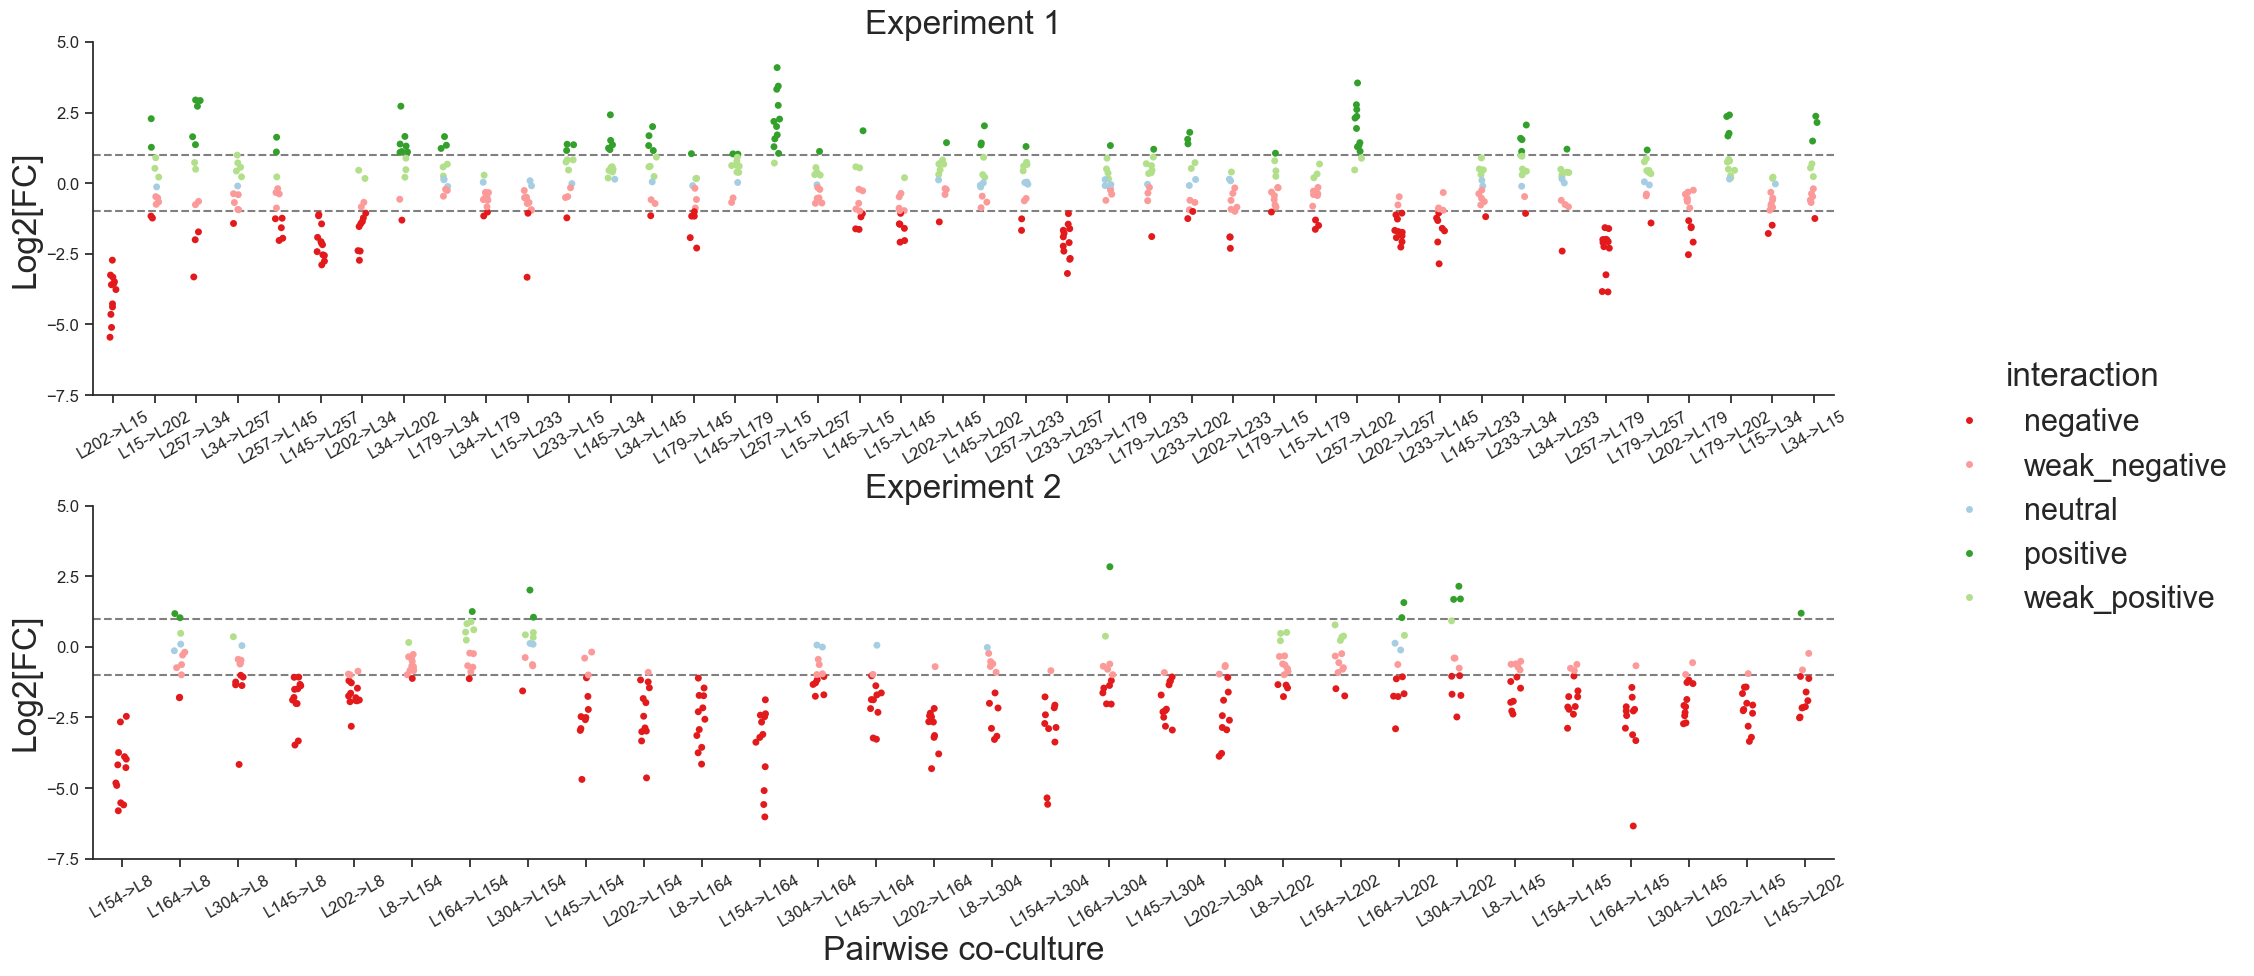

In [27]:
sns.set_theme(style="ticks", rc={"figure.figsize":(20, 5)}, font_scale=2)
g = sns.catplot(data=pairwise_exps_all, x="pair", y="Log2[FC]", sharex=False, row="exp", hue="interaction", aspect=4, kind="strip",  palette=palette)
g.refline(y=1, color="gray", linestyle="--")
g.refline(y=-1, color="gray", linestyle="--")
g.set_xlabels(label="Pairwise co-culture")
g.set_xticklabels(rotation=30, fontsize=12);
g.set_yticklabels(fontsize=12);
g.set_titles(template='{row_name}')
# plt.subplots_adjust(bottom=-0.3)
# plt.tight_layout()
plt.show()

In [28]:
# TODO: Reconcile this
pairwise_exps.loc[["L145->L202", "L202->L145"], :]

,microbe1,microbe2,strain,colonization,exp,Log2[FC],interaction
L145->L202,L145,L202,L202,1.430846e+08,Experiment 1,0.114414,neutral
L145->L202,L145,L202,L202,3.945921e+07,Experiment 2,-1.744020,negative
L202->L145,L145,L202,L145,6.073045e+08,Experiment 1,0.389058,weak_positive
L202->L145,L145,L202,L145,1.054735e+08,Experiment 2,-2.136482,negative


In [29]:
#  (frozenset({'L15', 'L233'}), 1),
#  (frozenset({'L15', 'L257'}), 1),
#  (frozenset({'L15', 'L34'}), 1)]
strain_ref = {"L15"}
strains = {"L233", "L237", "L34"}
data = []
fpairs_all = [frozenset([m1, m2]) for m1, m2 in zip(pairwise_exps.microbe1, pairwise_exps.microbe2)]
fpairs_select = [frozenset(["L15", "L233"]), frozenset(["L15", "L257"]), frozenset(["L15", "L34"])]
for fpair in fpairs_select:
    matches = [ind for ind, val in enumerate(fpairs_all) if fpair == val]
    item = pairwise_exps.iloc[matches, :]
    data.append(item)
pd.concat(data)

,microbe1,microbe2,strain,colonization,exp,Log2[FC],interaction
L233->L15,L15,L233,L15,6.992772e+07,Experiment 1,0.612698,weak_positive
L15->L233,L15,L233,L233,2.292603e+08,Experiment 1,-0.622189,weak_negative
L257->L15,L15,L257,L15,1.958033e+08,Experiment 1,2.098166,positive
L15->L257,L15,L257,L257,3.971282e+08,Experiment 1,-0.103810,neutral
L34->L15,L15,L34,L15,4.676548e+07,Experiment 1,0.032277,neutral
L15->L34,L15,L34,L34,4.050923e+07,Experiment 1,-0.666915,weak_negative


These pairs only have a singular direction of measurement because the measurments for the other strain are in a different media

## Read CommScores data

CommScores derived from the metabolic models reconstructed for each of the experimental microbial strains.

The following features are calculted:
1. Growth rates: Model1 growth rate, Model2 growth rate, Community growth rate
2. Metabolic Resource Overlap: MRO model1, MRO model2
3. Metabolic Interaction Potential: MIP model1, MIP model2, MIP costless model1, MIP costless model2
4. BioSynthetic score: BSS model1, BSS model2
5. PC: PC model1, PC model2, PC_comm
6. Growth yield difference: GYD
7. Biological interaction type: BIT
8. Functional similarity score: FS

Since, the interaction categorization derived from these experiments are undirected we average the values from both models in order to derived "undirected" features.

In [30]:
raw_commscores = pd.read_csv((rawdata_dir / "commscores_report.csv"), index_col=0).drop(["media"], axis=1)

In [31]:
with open((rawdata_dir / "gcf_leafid_map.txt")) as fid:
    gcf_leafid_rawmap = [line.strip().split("\t") for line in fid.readlines()]
gcf_leafid_map = {ids[0]: "L" + ids[2].split(" ")[-1].strip("Leaf") for ids in gcf_leafid_rawmap}

In [32]:
from utils import parse_commscores_data

In [33]:
commscores = parse_commscores_data(raw_commscores, gcf_leafid_map, dtype="directed")
commscores

,model1,model2,gr1,gr2,gr_comm,gyd,mro1,mro2,cip,mip1,mip2,mip_c1,mip_c2,bss1,bss2,pc1,pc2,pc_comm,fs
L202->L8,L8,L202,51.069,49.604,82.933,0.028687,75.610,64.583,16,1,15,0,4,26.829,70.833,0.92348,0.84237,0.88106,0.00000
L8->L202,L202,L8,49.604,51.069,82.933,-0.029534,64.583,75.610,16,15,1,4,0,70.833,26.829,0.84237,0.92348,0.88106,0.00000
L257->L8,L8,L257,44.903,120.250,90.798,-1.677995,75.610,81.579,19,6,2,1,1,70.732,63.158,1.01110,1.00410,1.00750,0.30959
L8->L257,L257,L8,120.250,44.903,90.798,0.626586,81.579,75.610,19,2,6,1,1,63.158,70.732,1.00410,1.01110,1.00750,0.30959
L145->L8,L8,L145,44.903,48.135,68.806,-0.071977,78.049,64.000,13,0,7,0,3,31.707,72.000,0.76616,0.71937,0.74203,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L164->L15,L15,L164,65.365,58.247,111.030,0.108896,66.667,79.070,22,3,6,3,1,64.706,72.093,0.84928,0.95308,0.89819,0.25098
L233->L164,L164,L233,58.247,57.704,75.719,0.009322,88.372,86.364,18,2,1,2,1,69.767,61.364,0.64999,0.65610,0.65303,0.44441
L164->L233,L233,L164,57.704,58.247,75.719,-0.009410,86.364,88.372,18,1,2,1,2,61.364,69.767,0.65610,0.64999,0.65303,0.44441
L233->L15,L15,L233,65.365,57.704,113.150,0.117203,74.510,86.364,21,5,2,3,0,70.588,70.455,0.86554,0.98047,0.91943,0.29827


In [34]:
# Experimental set of micobes and verification
experimental_mono_microbes = set(monoculture_exps.microbe) - {"SynCom7"}
experimental_cocul_microbes = set(pairwise_exps.microbe1) | set(pairwise_exps.microbe2)
experimental_mono_microbes == experimental_cocul_microbes

True

In [35]:
# Computational set of microbes and missing models
models = set(commscores.model1) | set(commscores.model2)
print(f"Missing models {experimental_cocul_microbes - models}")

Missing models {'L304'}


In [36]:
data_raw_all = pairwise_exps.join(commscores, how="inner").drop(["microbe1", "microbe2", "model1", "model2"], axis=1)
data_raw_all = data_raw_all[data_raw_all.interaction.isin(interaction_filter_all)]
data_raw_nonneu = data_raw_all[data_raw_all.interaction.isin(interaction_filter_nonneu)]
data_raw_strong = data_raw_all[data_raw_all.interaction.isin(interaction_filter_strong)]

In [37]:
data_all = data_raw_all.drop(["colonization",  "Log2[FC]", "strain"], axis=1)
data_nonneu = data_raw_nonneu.drop(["colonization",  "Log2[FC]", "strain"], axis=1)
data_strong = data_raw_strong.drop(["colonization",  "Log2[FC]", "strain"], axis=1)

In [38]:
data_all.interaction.value_counts()

negative         22
weak_negative    18
weak_positive    12
neutral           7
positive          3
Name: interaction, dtype: int64

## Validation of metabolic models

In [39]:
def annotate(data, **kws):
    import scipy as sp
    x1, x2 = kws["x1"], kws["x2"]
    r, p = sp.stats.pearsonr(data[x1], data[x2])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

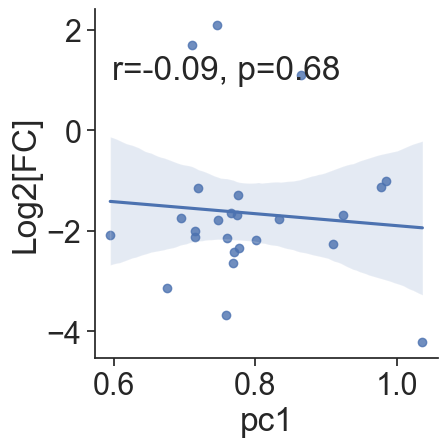

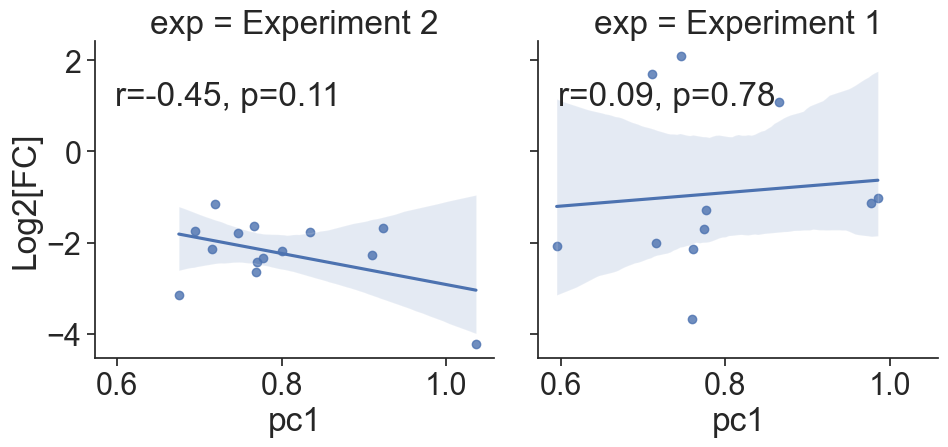

In [40]:
g = sns.lmplot(data=data_raw_strong, x="pc1", y="Log2[FC]")
g.map_dataframe(annotate, x1="pc1", x2="Log2[FC]")
g = sns.lmplot(data=data_raw_strong, x="pc1", y="Log2[FC]", col="exp")
g.map_dataframe(annotate, x1="pc1", x2="Log2[FC]")
plt.show()

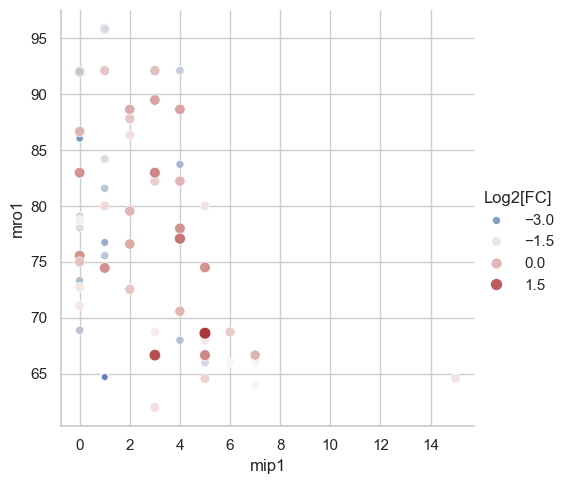

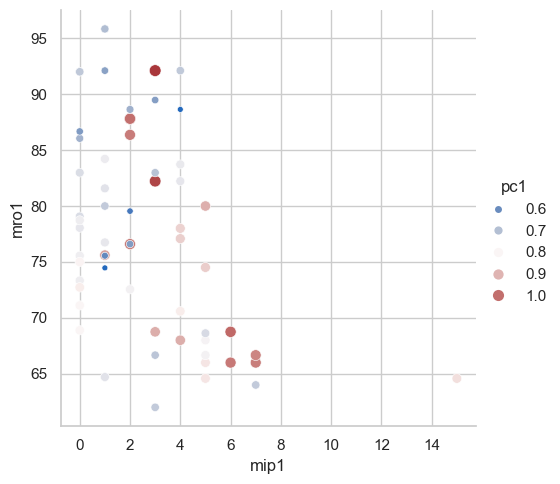

In [41]:
sns.set_theme(style="whitegrid", rc={"figure.figsize":(20, 5)})
sns.relplot(data=data_raw_all, x="mip1", y="mro1", hue="Log2[FC]", size="Log2[FC]", palette="vlag")
sns.relplot(data=data_raw_all, x="mip1", y="mro1", hue="pc1", size="pc1", palette="vlag")
plt.show()

In [42]:
from collections import Counter

s1 = [frozenset(i.split("->")) for i in data_raw_all.index]
c = Counter(s1)
c.most_common()

[(frozenset({'L145', 'L202'}), 4),
 (frozenset({'L145', 'L15'}), 2),
 (frozenset({'L145', 'L154'}), 2),
 (frozenset({'L145', 'L164'}), 2),
 (frozenset({'L145', 'L179'}), 2),
 (frozenset({'L145', 'L233'}), 2),
 (frozenset({'L145', 'L257'}), 2),
 (frozenset({'L145', 'L34'}), 2),
 (frozenset({'L145', 'L8'}), 2),
 (frozenset({'L15', 'L179'}), 2),
 (frozenset({'L15', 'L202'}), 2),
 (frozenset({'L15', 'L233'}), 2),
 (frozenset({'L15', 'L257'}), 2),
 (frozenset({'L15', 'L34'}), 2),
 (frozenset({'L154', 'L164'}), 2),
 (frozenset({'L154', 'L202'}), 2),
 (frozenset({'L154', 'L8'}), 2),
 (frozenset({'L164', 'L202'}), 2),
 (frozenset({'L164', 'L8'}), 2),
 (frozenset({'L179', 'L202'}), 2),
 (frozenset({'L179', 'L233'}), 2),
 (frozenset({'L179', 'L257'}), 2),
 (frozenset({'L179', 'L34'}), 2),
 (frozenset({'L202', 'L233'}), 2),
 (frozenset({'L202', 'L257'}), 2),
 (frozenset({'L202', 'L34'}), 2),
 (frozenset({'L202', 'L8'}), 2),
 (frozenset({'L233', 'L257'}), 2),
 (frozenset({'L233', 'L34'}), 2),
 (fr

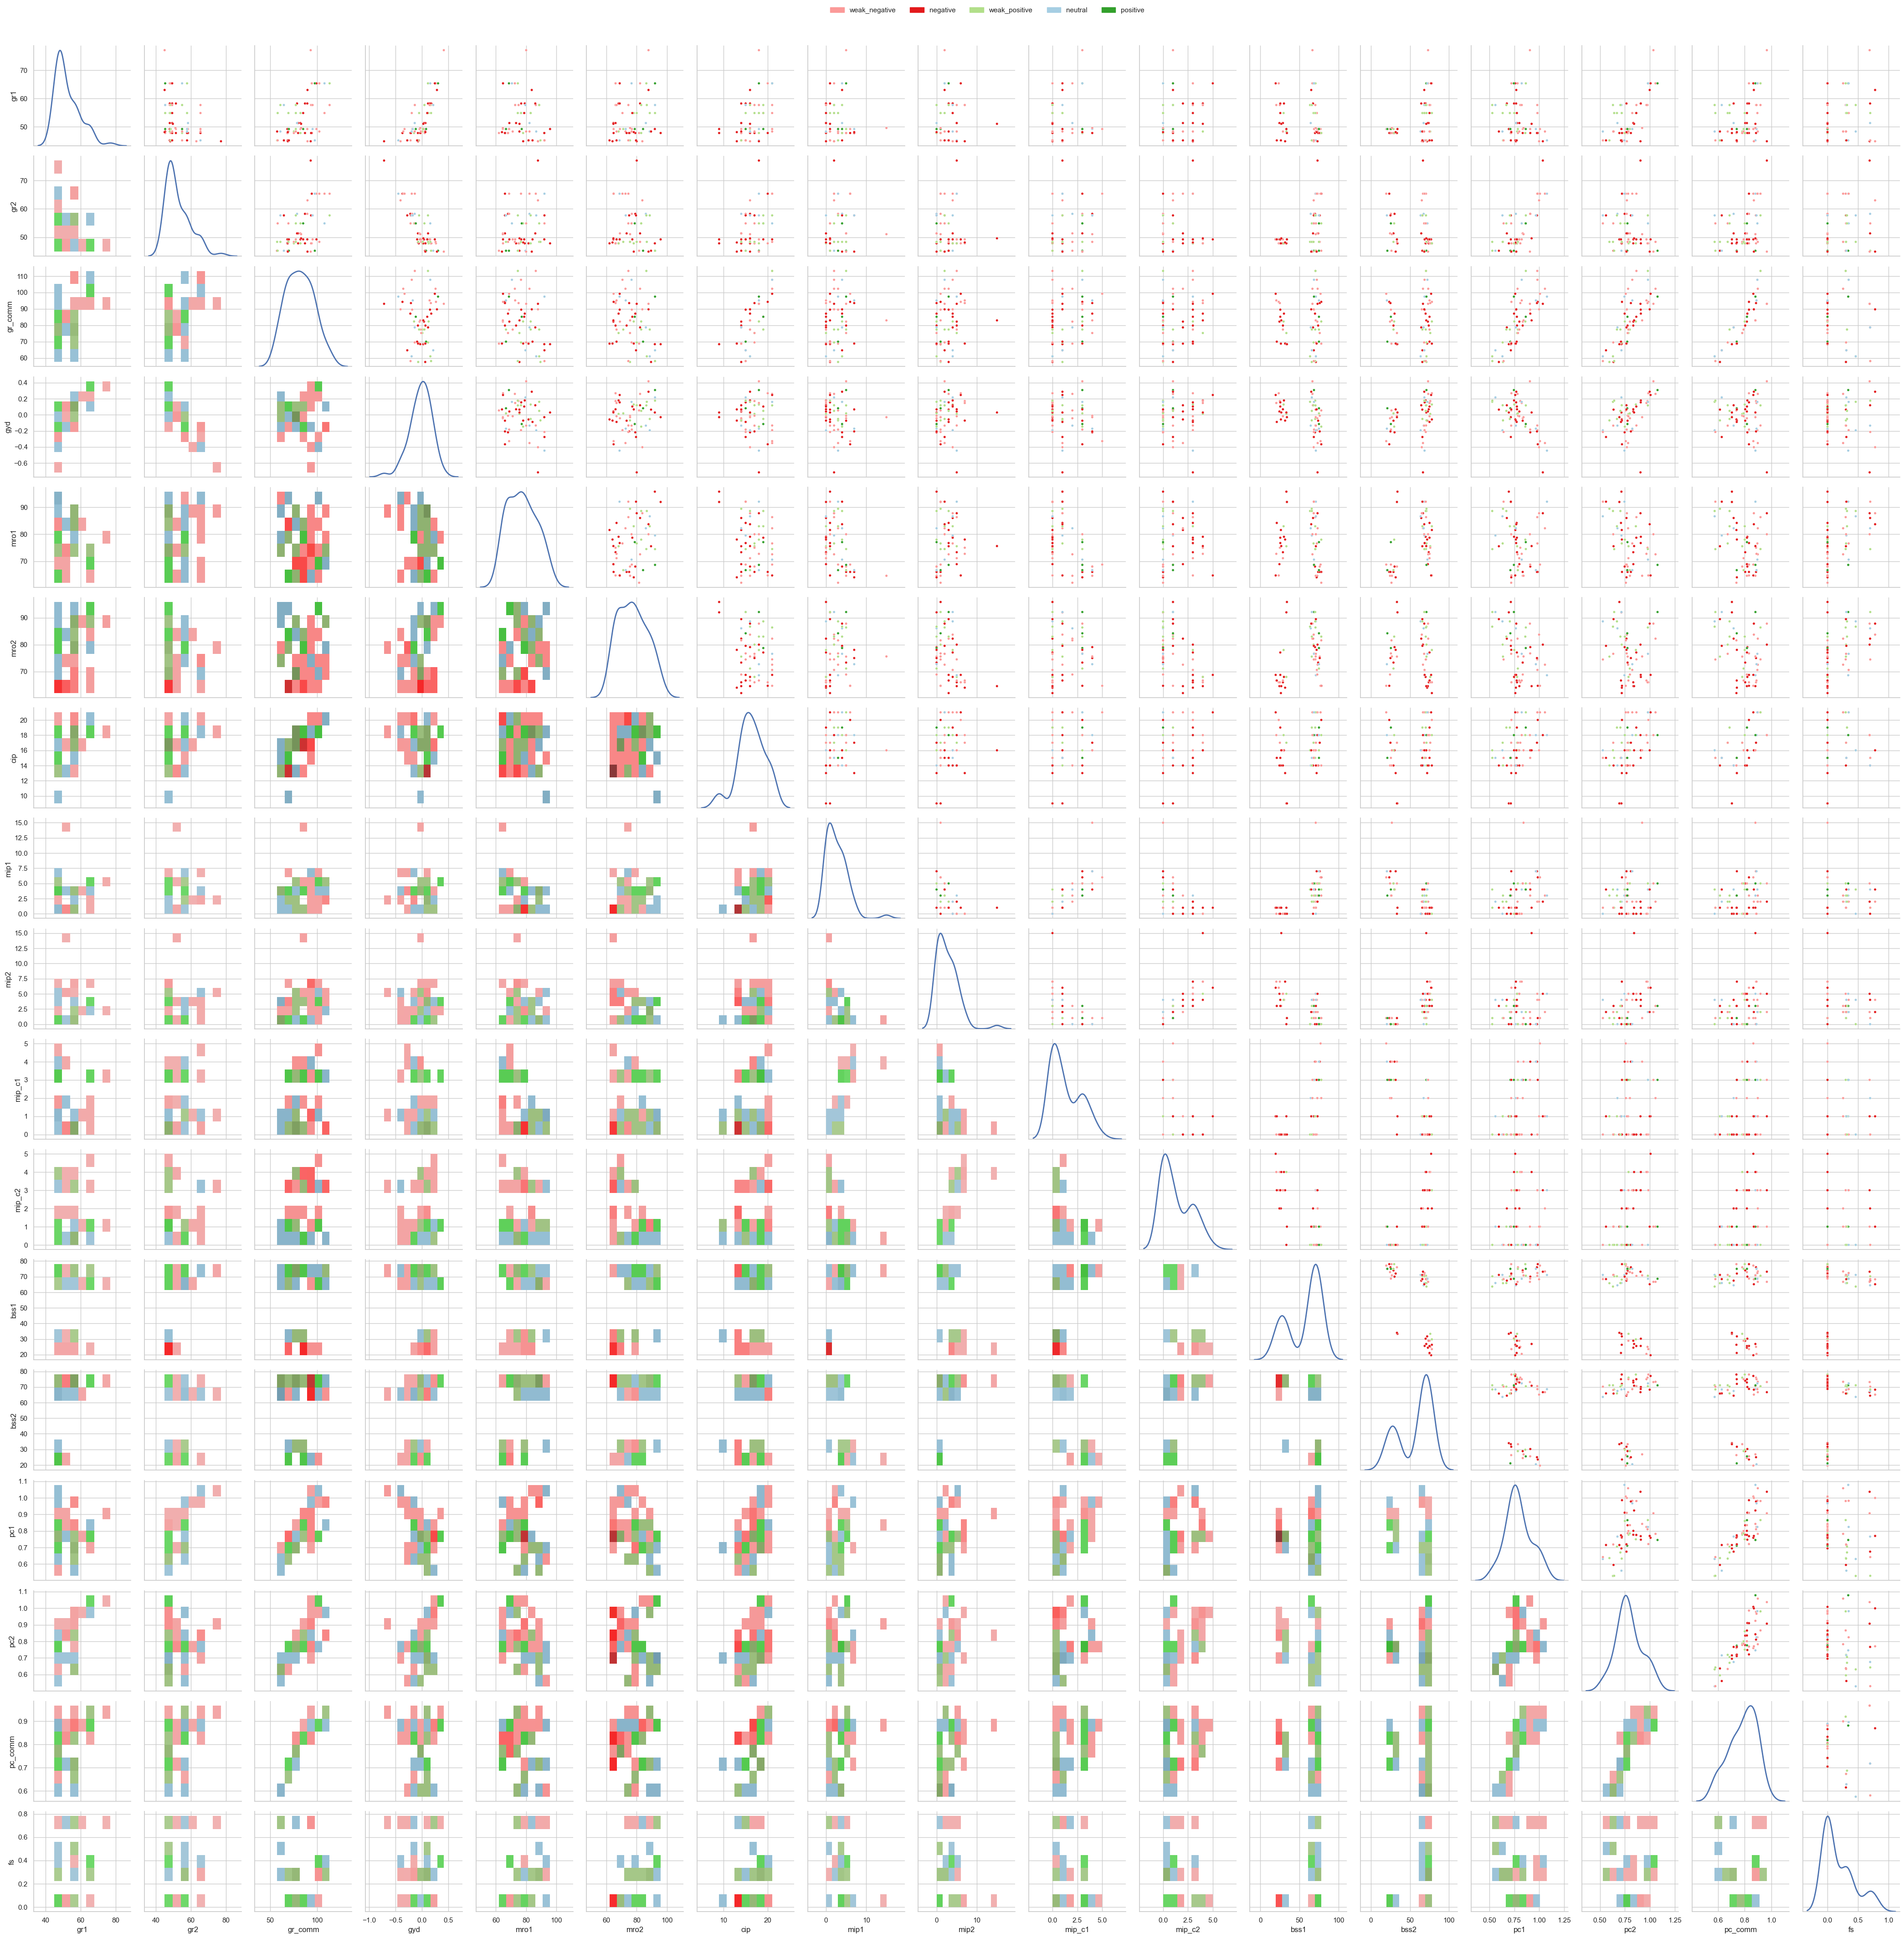

In [43]:
vars = ["gr1", "gr2", "gr_comm", "gyd", "mro1", "mro2", "cip", "mip1", "mip2", "mip_c1", "mip_c2", "bss1", "bss2", "pc1", "pc2", "pc_comm", "fs"]
# vars = ["gr1", "gr_comm", "gyd", "mro1", "cip", "mip1", "mip_c1", "bss1", "pc1", "pc_comm", "fs"]
data_pair_plot = data_raw_all[vars + ["interaction"]]
data_pair_plot.index = range(data_pair_plot.shape[0])
g = sns.PairGrid(data=data_pair_plot, diag_sharey=False, vars=vars, hue="interaction", palette=palette)
g.map_diag(sns.kdeplot, lw=2, hue=None)
g.map_upper(sns.scatterplot, s=15)
# g.map_lower(sns.regplot, scatter_kws = {'alpha': 0.7, 's':10})
g.map_lower(sns.histplot)
g.add_legend()
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, 1), ncol=5, title=None, frameon=False)
plt.show()

## Plot correlations

In [44]:
# Check with colonization
y = data_raw_strong.loc[:, "Log2[FC]"].copy(deep=True)
pc = data_raw_strong.loc[:, "pc1"].copy(deep=True)
# cols_for_corr = ["gr_comm", "mro", "mip", "cip", "mip_c", "bss", "pc_comm", "gyd", "fs"]
# cols_for_corr = ["gr1", "gr2", "mro1", "mro2", "mip1", "mip2", "mip_c1", "mip_c2", "bss1", "bss2", "pc1", "pc2"]
cols_for_corr = ["gr1", "gr2", "gr_comm", "gyd", "mro1", "mro2", "cip", "mip1", "mip2", "mip_c1", "mip_c2", "bss1", "bss2", "pc1", "pc2", "pc_comm", "fs"]
label_correlations = pd.Series({col: y.corr(data_raw_strong.loc[:, col]) for col in data_raw_strong.columns if col in cols_for_corr})
pc_correlations = pd.Series({col: pc.corr(data_raw_strong.loc[:, col]) for col in data_raw_strong.columns if col in cols_for_corr})
order = label_correlations.abs().sort_values()
order_pc = pc_correlations.abs().sort_values()
label_correlations = label_correlations[order.index]
pc_correlations = pc_correlations[order_pc.index]
label_correlations_df = pd.DataFrame(data={"x": label_correlations.index, "y": label_correlations.values})
pc_correlations_df = pd.DataFrame(data={"x": pc_correlations.index, "y": pc_correlations.values})

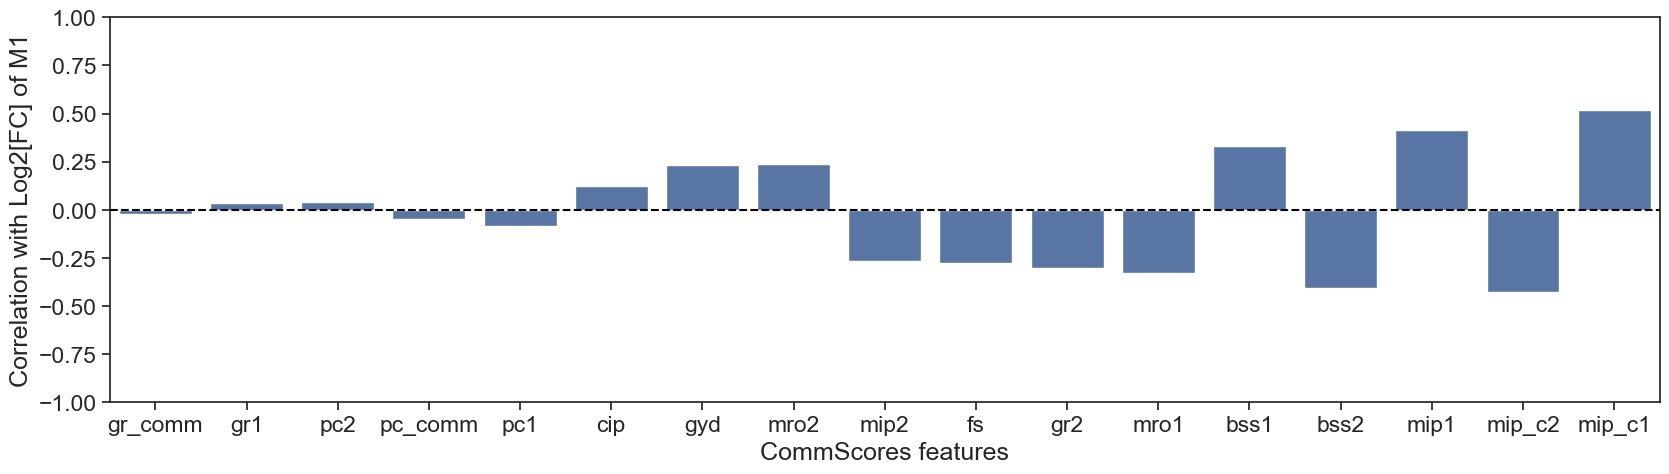

In [45]:
sns.set_theme(style="ticks", rc={"figure.figsize":(20, 5)}, font_scale=1.5)
g = sns.barplot(data=label_correlations_df, x="x", y="y", color="b")
g.axhline(0.0, ls="--", color="black")
g.set(xlabel="CommScores features", ylabel="Correlation with Log2[FC] of M1", ylim=(-1, 1))
plt.savefig("correlation.png")
plt.show()

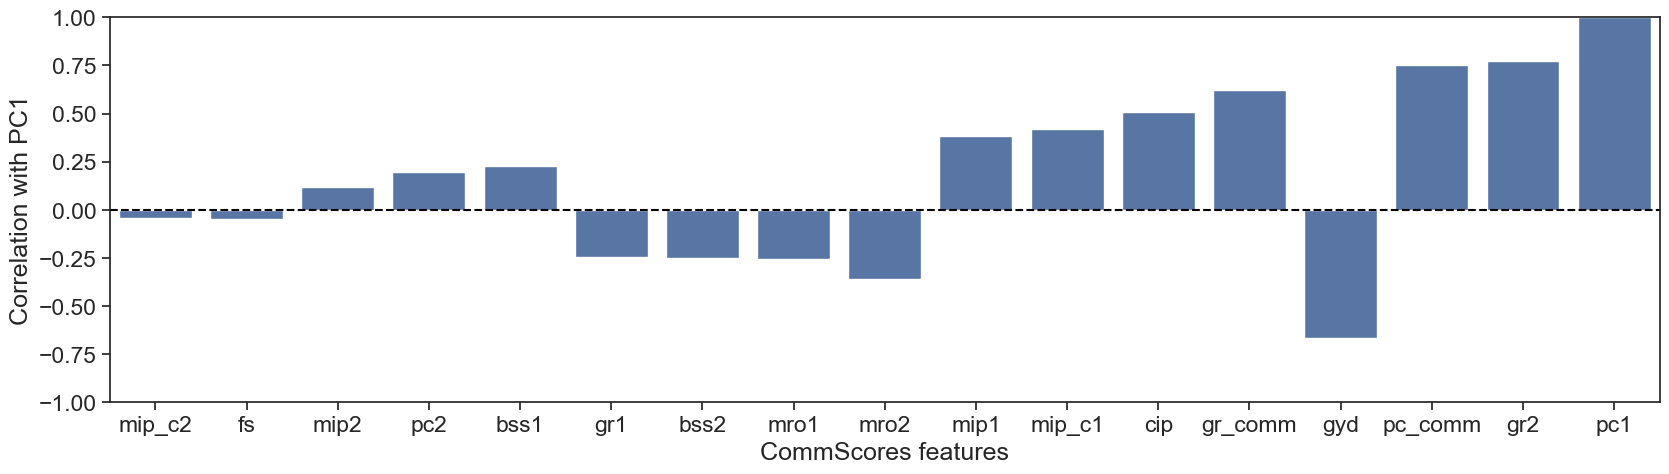

In [46]:
sns.set_theme(style="ticks", rc={"figure.figsize":(20, 5)}, font_scale=1.5)
g = sns.barplot(data=pc_correlations_df, x="x", y="y", color="b")
g.axhline(0.0, ls="--", color="black")
g.set(xlabel="CommScores features", ylabel="Correlation with PC1", ylim=(-1, 1))
plt.savefig("PC1correlation.png")
plt.show()

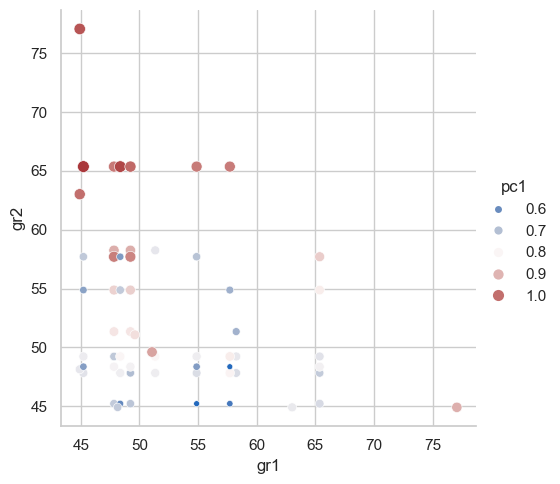

In [47]:
sns.set_theme(style="whitegrid", rc={"figure.figsize":(20, 5)})
sns.relplot(data=data_raw_all, x="gr1", y="gr2", hue="pc1", size="pc1", palette="vlag")
plt.show()

In [48]:
data_melt_all = data_all.drop(["exp"], axis=1).melt(id_vars=["interaction"], var_name="column")
data_melt_nonneu = data_nonneu.drop(["exp"], axis=1).melt(id_vars=["interaction"], var_name="column")
data_melt_strong = data_strong.drop(["exp"], axis=1).melt(id_vars=["interaction"], var_name="column")
data_melt_all

,interaction,column,value
0,weak_negative,gr1,65.36500
1,negative,gr1,51.34100
2,negative,gr1,58.24700
3,weak_positive,gr1,48.35700
4,neutral,gr1,49.22600
...,...,...,...
1049,weak_negative,fs,0.70211
1050,negative,fs,0.00000
1051,weak_negative,fs,0.69180
1052,negative,fs,0.78190


## Plot distribution of CommScores metrics

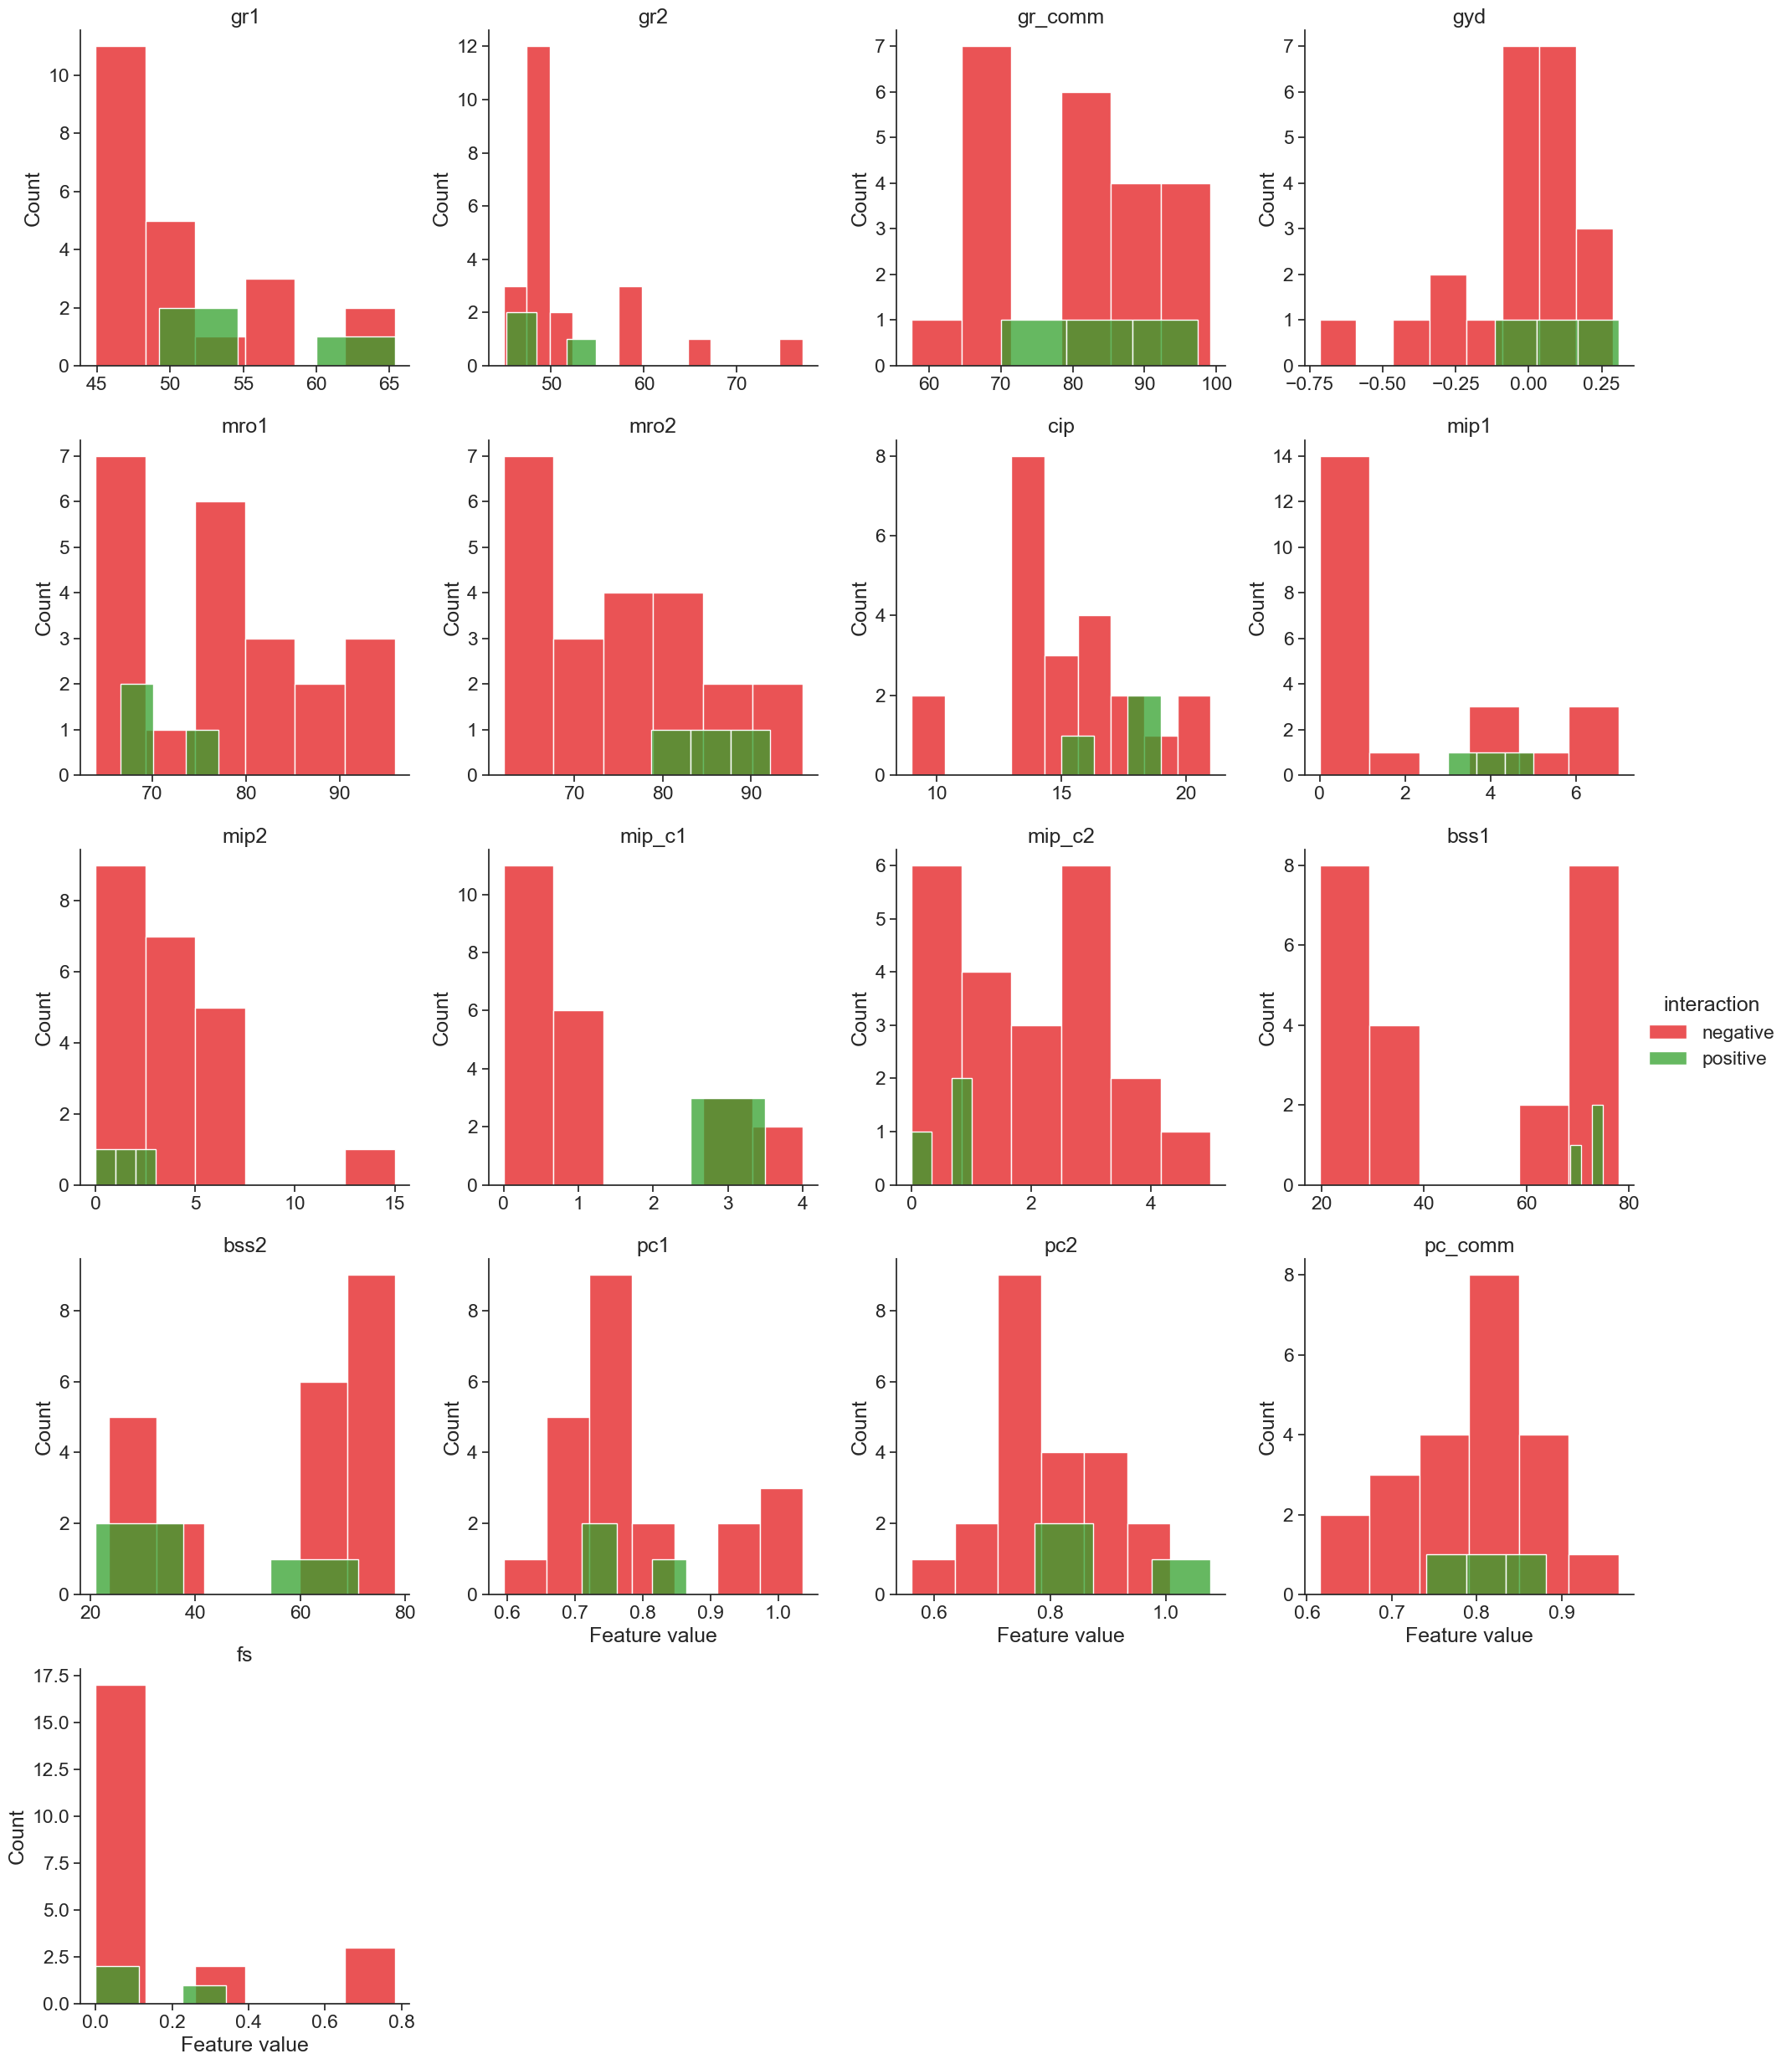

In [49]:
sns.set_theme(style="ticks", rc={"figure.figsize":(20, 5)}, font_scale=1.5)
g = sns.FacetGrid(data_melt_strong, col="column", col_wrap=4, sharex=False, sharey=False, hue="interaction", height=5, palette=palette)
# g.map_dataframe(sns.histplot, x="value", stat="count", common_norm=False, element="step", bins=10)
g.map_dataframe(sns.histplot, x="value", stat="count")
g.set_xlabels(label="Feature value")
g.set_titles(template="{col_name}")
g.add_legend()
plt.savefig("scoreDistribution.png")
plt.show()

In [50]:
data_melt_all_numeric = data_melt_all.loc[data_melt_all.column != "bit", :]
data_melt_nonneu_numeric = data_melt_nonneu.loc[data_melt_nonneu.column != "bit", :]
data_melt_strong_numeric = data_melt_strong.loc[data_melt_strong.column != "bit", :]

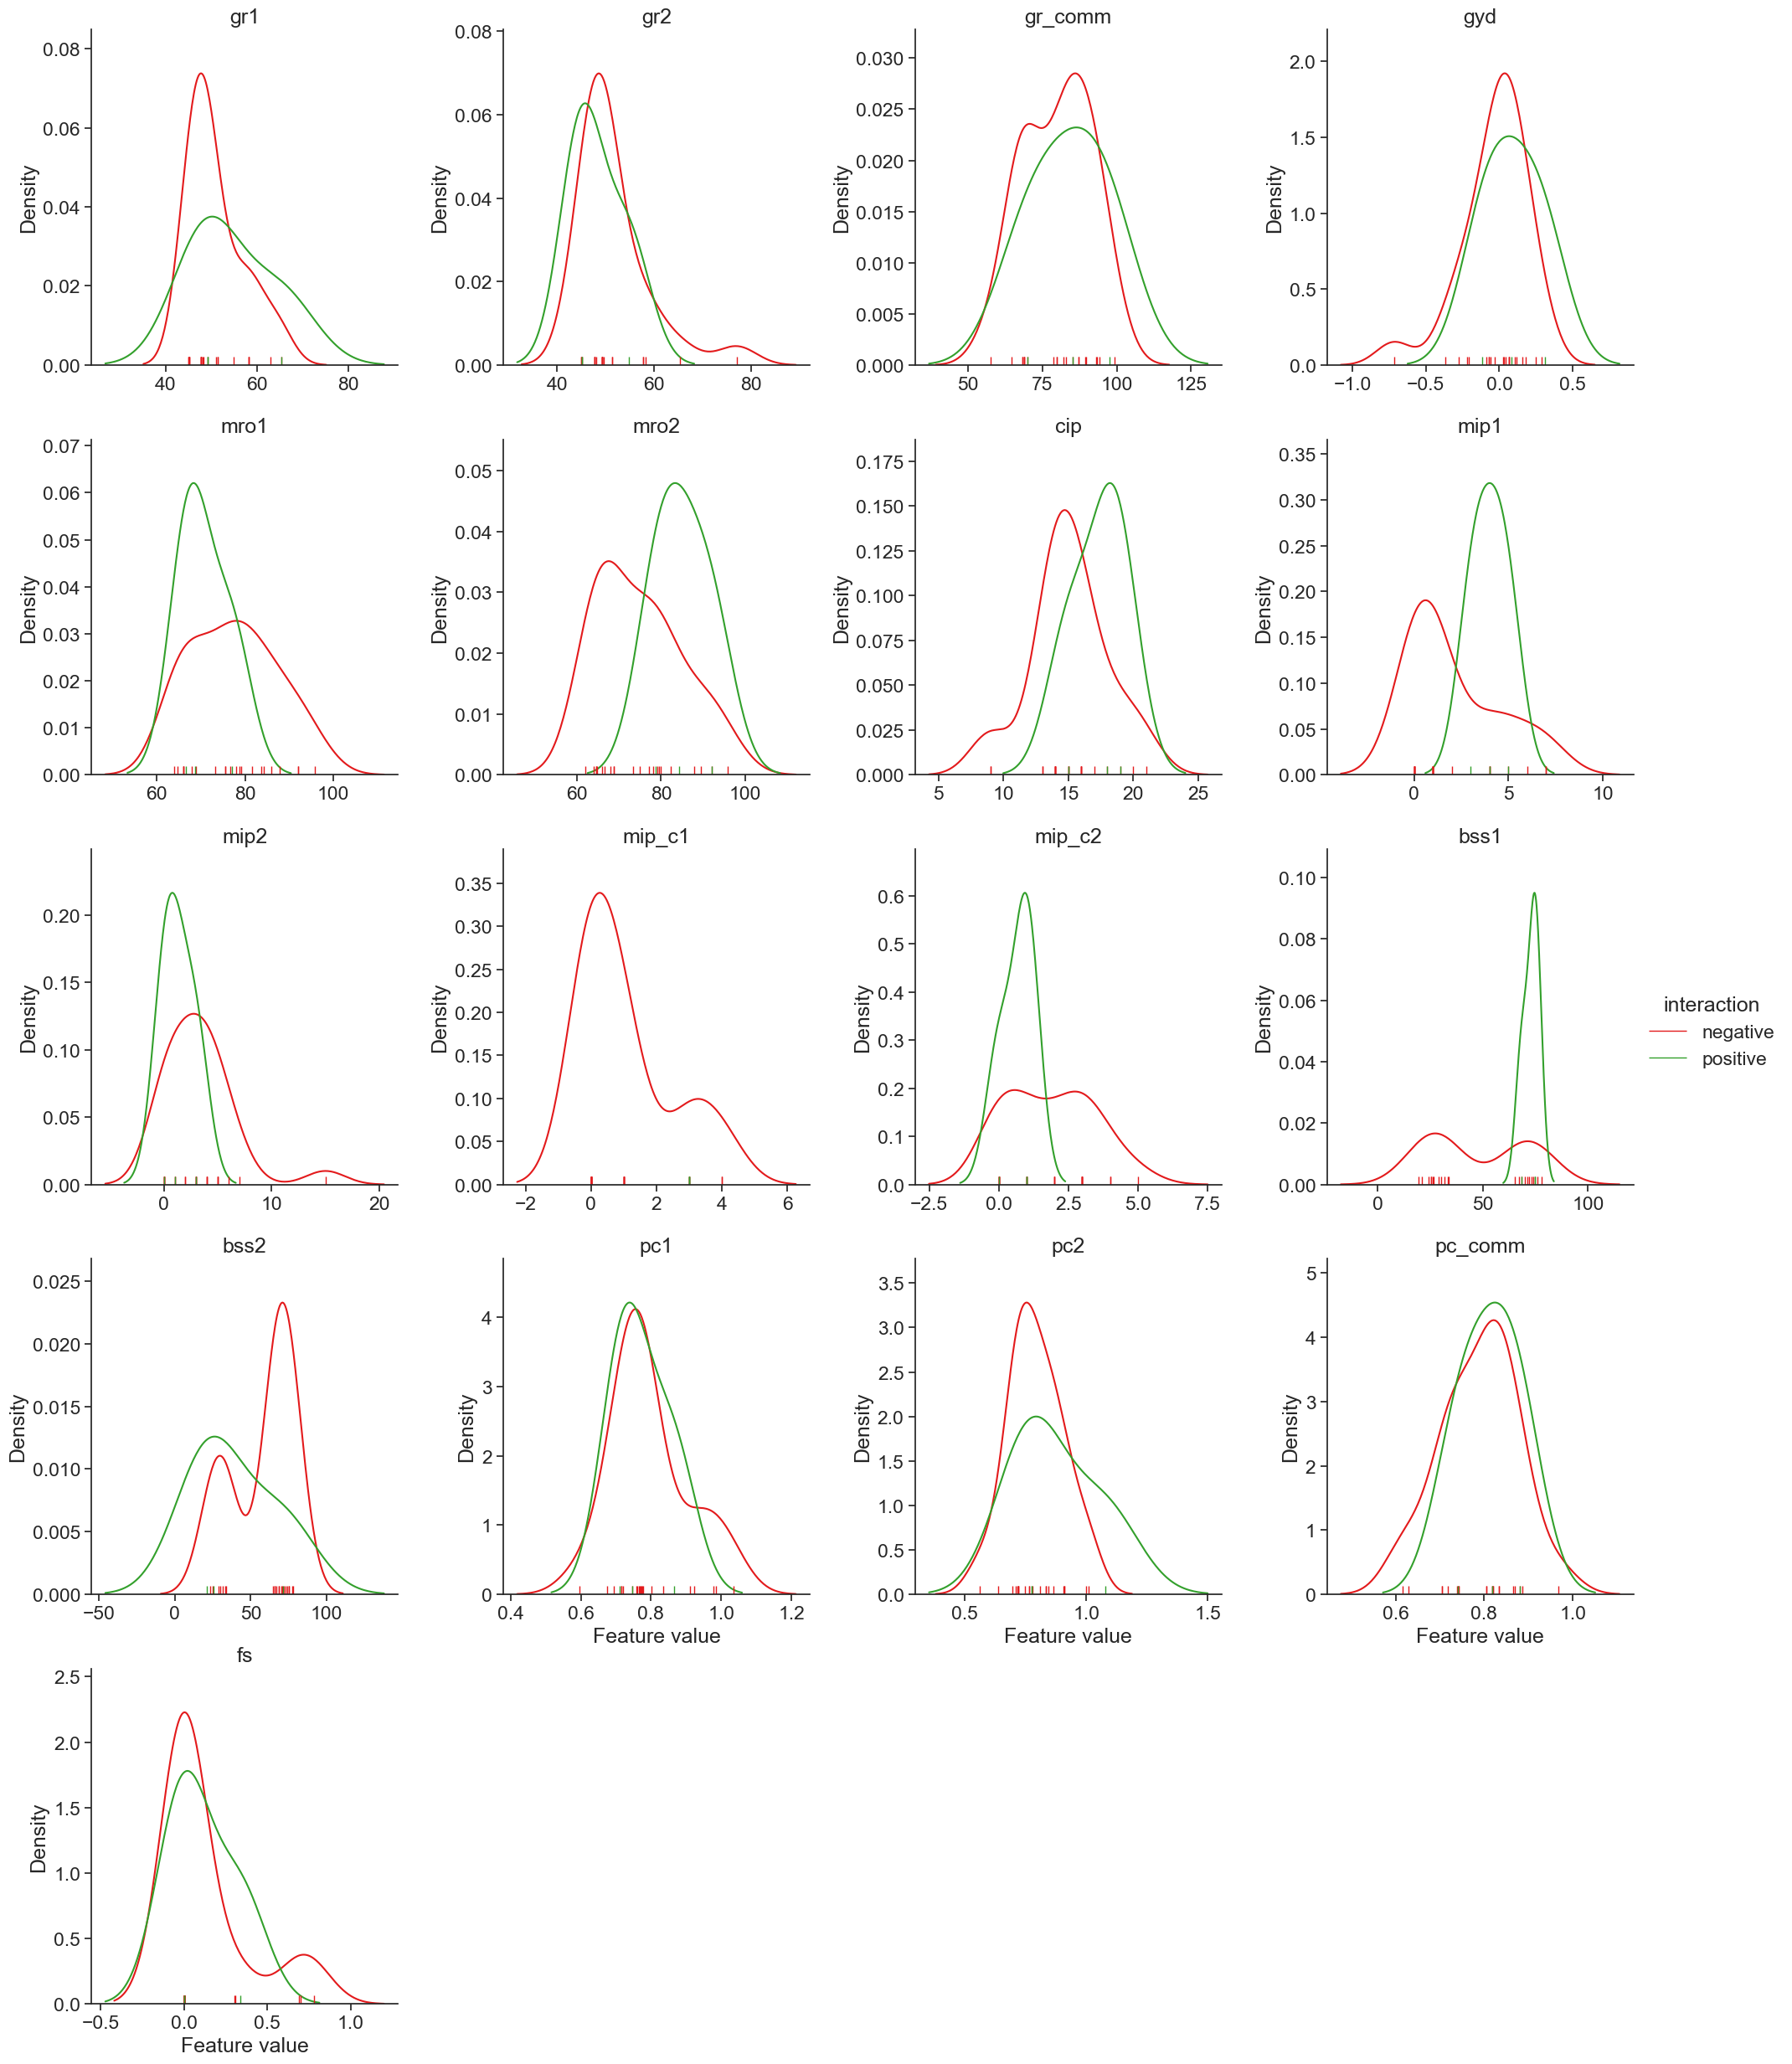

In [51]:
sns.set_theme(style="ticks", rc={"figure.figsize":(20, 5)}, font_scale=1.5)
g = sns.FacetGrid(data_melt_strong_numeric, col="column", col_wrap=4, sharex=False, sharey=False, hue="interaction", height=5, palette=palette)
g.map_dataframe(sns.kdeplot, x="value")
g.map_dataframe(sns.rugplot, x="value")
g.set_titles(template="{col_name}")
g.set_xlabels(label="Feature value")
g.add_legend()
plt.savefig("lineScoreDistribution.png")
plt.show()

## Plot statistical significance between CommScores metrics in different interaction categories

In [1]:
! pip install statannotations
from statannotations.Annotator import Annotator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 12.3 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pandas: filename=pandas-1.5.3-cp312-cp312-macosx_14_0_x86_64.whl size=11308519 sha256=9defa2c467522d4249735f602ea41b084f82c771351757805d096130f0d67907
  Stored in directory: /Users/afreiburger/Library/Caches/pip/wheels/fb/83/18/8e7307aa1185c5498c5490e4d9c8a1732d9f1056e86c3491c6
Successfully built pandas
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
commscores 0.1.0 requires pandas<3.0.0,>=2.2.2, but you have pandas 1.5.3 which is incompatible.


AttributeError: module 'matplotlib.cm' has no attribute 'register_cmap'

In [ ]:
pairs = [("positive", "negative"),]
plotting_parameters = {
    "x": "interaction",
    "y": "value",
    "order": interaction_filter_all,
    "palette": palette
}
annotator = Annotator(None, pairs)

negative vs. positive: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.737e-01 U_stat=1.950e+01
negative vs. positive: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.751e-01 U_stat=4.400e+01
negative vs. positive: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:4.767e-01 U_stat=2.400e+01
negative vs. positive: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:4.461e-01 U_stat=2.300e+01
negative vs. positive: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.795e-01 U_stat=4.400e+01
negative vs. positive: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.028e-01 U_stat=1.300e+01
negative vs. positive: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.759e-01 U_stat=1.650e+01
negative vs. positive: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.574e-01 U_stat=1.600e+01
negative vs. positive: Mann-Whit

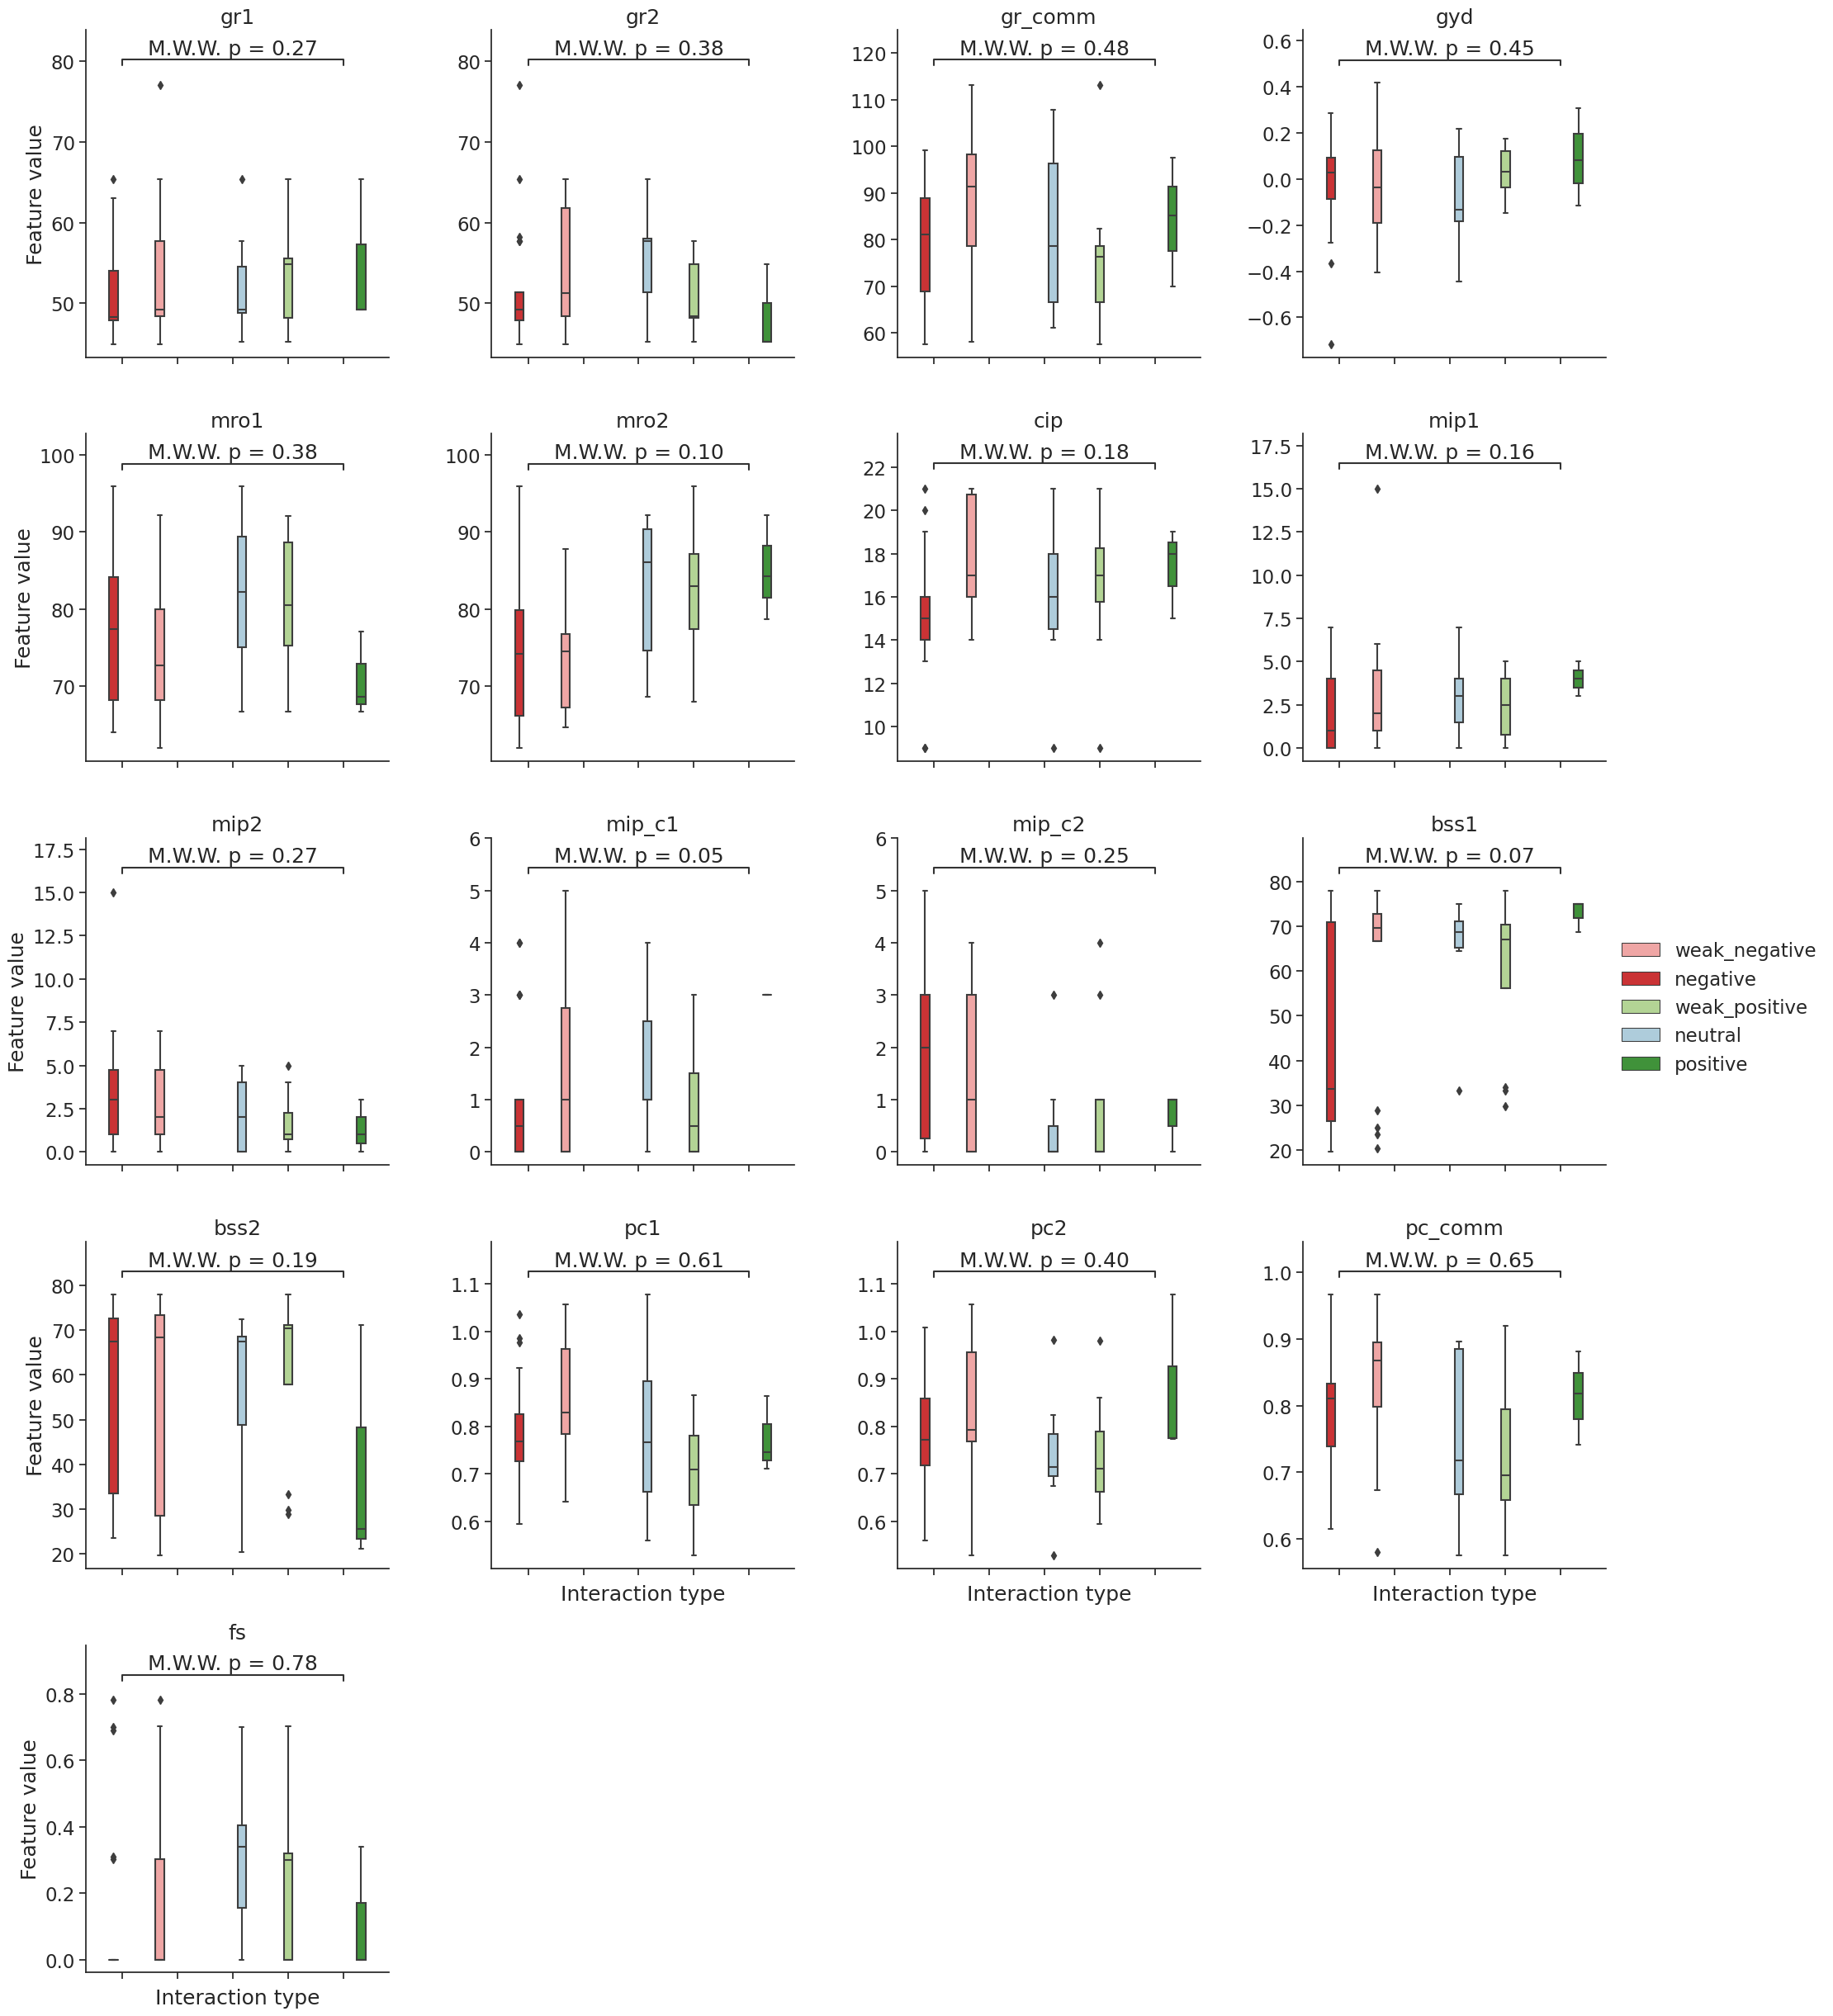

In [ ]:
sns.set_theme(style="ticks", rc={"figure.figsize":(20, 5)}, font_scale=1.5)
g = sns.FacetGrid(data=data_melt_all_numeric, col="column", sharey=False,  col_wrap=4, height=5)
g.map_dataframe(annotator.plot_and_annotate_facets, plot="boxplot", hue="interaction", plot_params=plotting_parameters, configuration={"test": "Mann-Whitney", "comparisons_correction": "bonf", "text_format": "simple"}, annotation_func="apply_test");
g.set_xlabels(label="Interaction type")
g.set_ylabels(label="Feature value")
g.set_titles(template="{col_name}")
g.set_xticklabels(rotation=30)
g.add_legend()
plt.savefig("scoreDistributionStats.png")
plt.show()

## Correlations between models and experiments

In [ ]:
gr_dict = dict()
for _, row in commscores.iterrows():
    key1 = row.model1
    value1 = row.gr1
    key2 = row.model2
    value2 = row.gr2
    gr_dict[key1] = value1
    gr_dict[key2] = value2
gr_df = pd.Series(gr_dict)
gr_df.name = "gr"

In [ ]:
monoculture_gr = monoculture_exps.join(gr_df, how="inner")
monoculture_gr.index = range(monoculture_gr.shape[0])
monoculture_gr["Log10[C]"] = np.log10(monoculture_gr["colonization"])
monoculture_gr

,microbe,colonization,dilution,exp,gr,Log10[C]
0,L145,4.637548e+08,0.0001,Experiment 1,47.823,8.666288
1,L145,1.319442e+08,0.0010,Experiment 2,47.823,8.120390
2,L15,4.573082e+07,0.0010,Experiment 1,65.365,7.660209
3,L154,1.014106e+08,0.0010,Experiment 2,51.341,8.006083
4,L164,3.404024e+07,0.0010,Experiment 2,58.247,7.531993
5,L179,2.234598e+08,0.0001,Experiment 1,48.357,8.349199
6,L202,1.321754e+08,0.0010,Experiment 1,49.226,8.121151
7,L202,8.552140e+07,0.0010,Experiment 2,49.226,7.932075
8,L233,3.528796e+08,0.0001,Experiment 1,57.704,8.547626
9,L257,4.267570e+08,0.0001,Experiment 1,45.215,8.630181


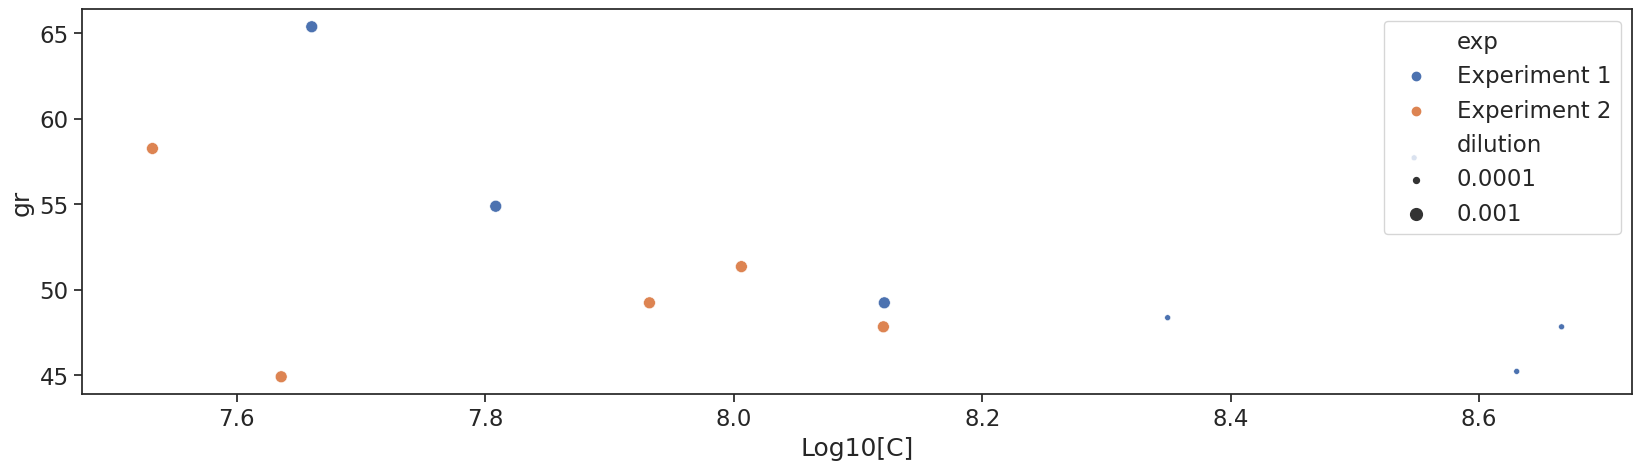

In [ ]:
g = sns.scatterplot(data=monoculture_gr, x="Log10[C]", y="gr", hue="exp", size="dilution")
plt.legend(loc="upper right")
plt.show()

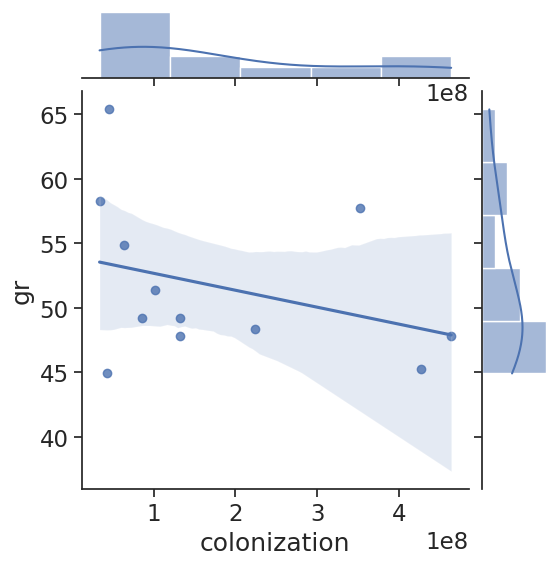

In [ ]:
sns.jointplot(data=monoculture_gr, x="colonization", y="gr", kind="reg")
plt.show()

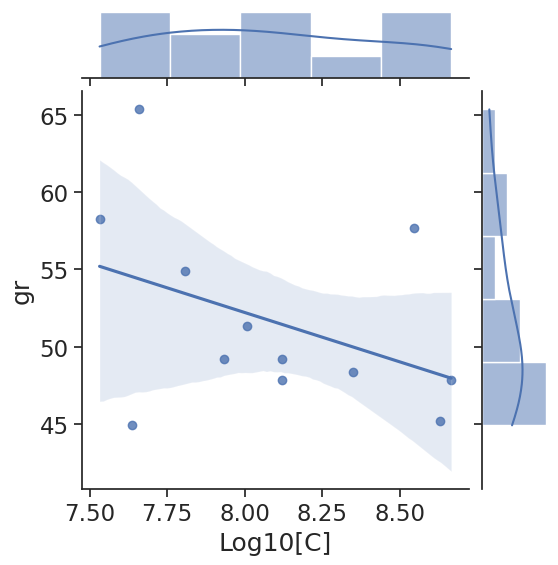

In [ ]:
sns.jointplot(data=monoculture_gr, x="Log10[C]", y="gr", kind="reg")
plt.show()

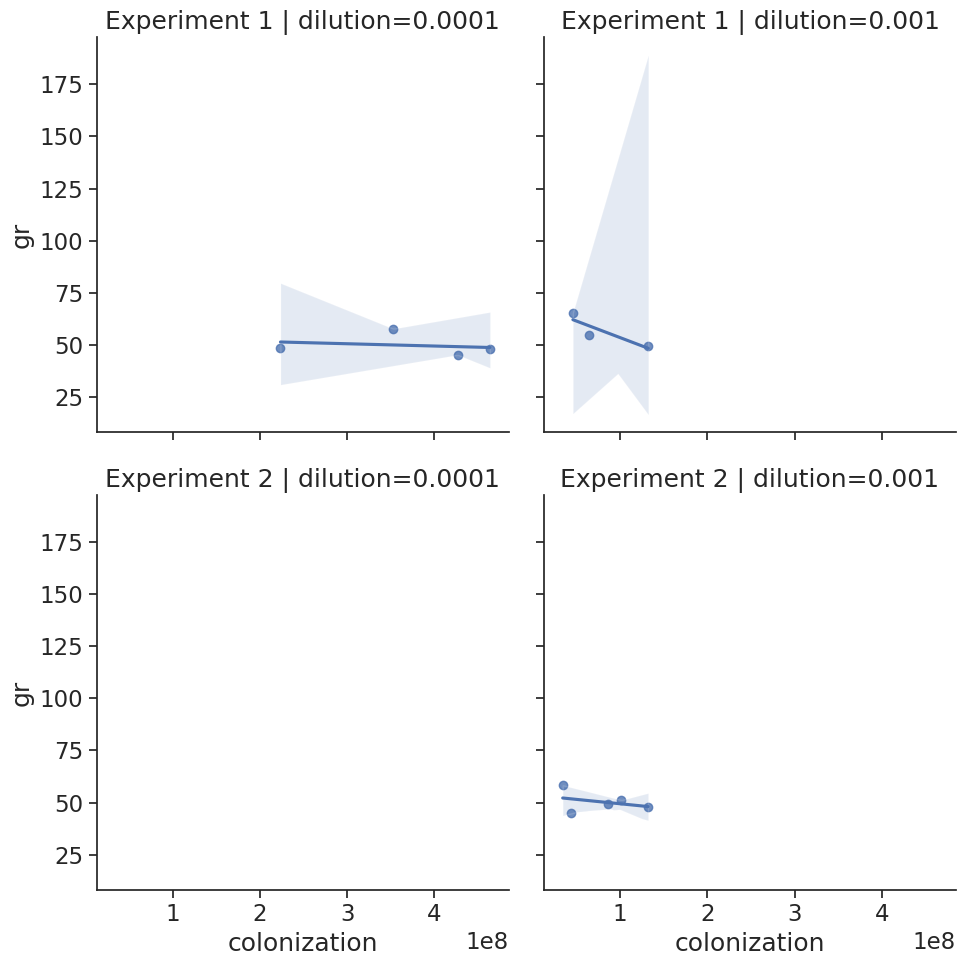

In [ ]:
g = sns.lmplot(data=monoculture_gr, x="colonization", y="gr", row="exp", col="dilution")
g.set_titles(template="{row_name} | dilution={col_name}")
plt.show()

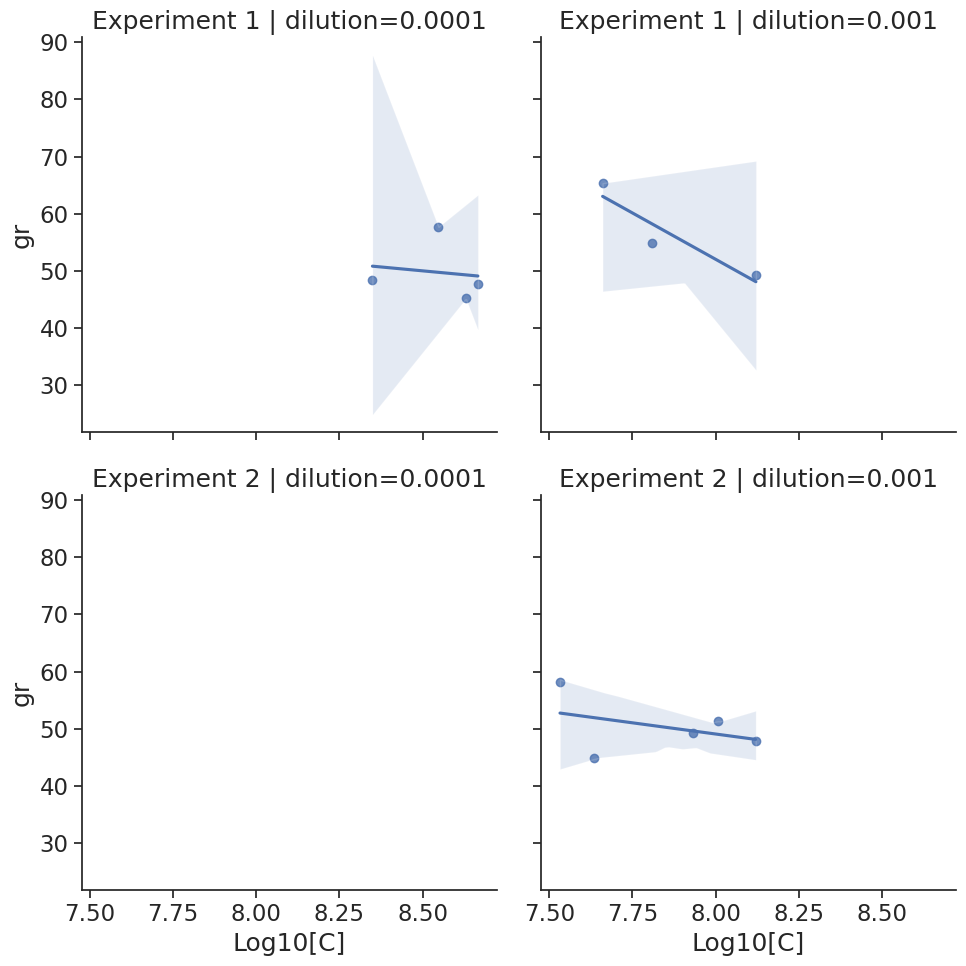

In [ ]:
g = sns.lmplot(data=monoculture_gr, x="Log10[C]", y="gr", row="exp", col="dilution")
g.set_titles(template="{row_name} | dilution={col_name}")
plt.show()

In [ ]:
data_raw_all = pairwise_exps.join(commscores, how="inner").drop(["microbe1", "microbe2", "model1", "model2"], axis=1)
data_raw_all = data_raw_all[data_raw_all.interaction.isin(interaction_filter_all)]

In [ ]:
y = data_raw_all.loc[:, "gr1"].copy(deep=True)
cols_for_corr = ["colonization", "Log2[FC]"]
label_correlations = pd.Series({col: y.corr(data_raw_all.loc[:, col]) for col in data_raw_all.columns if col in cols_for_corr})
order = label_correlations.abs().sort_values()
label_correlations = label_correlations[order.index]

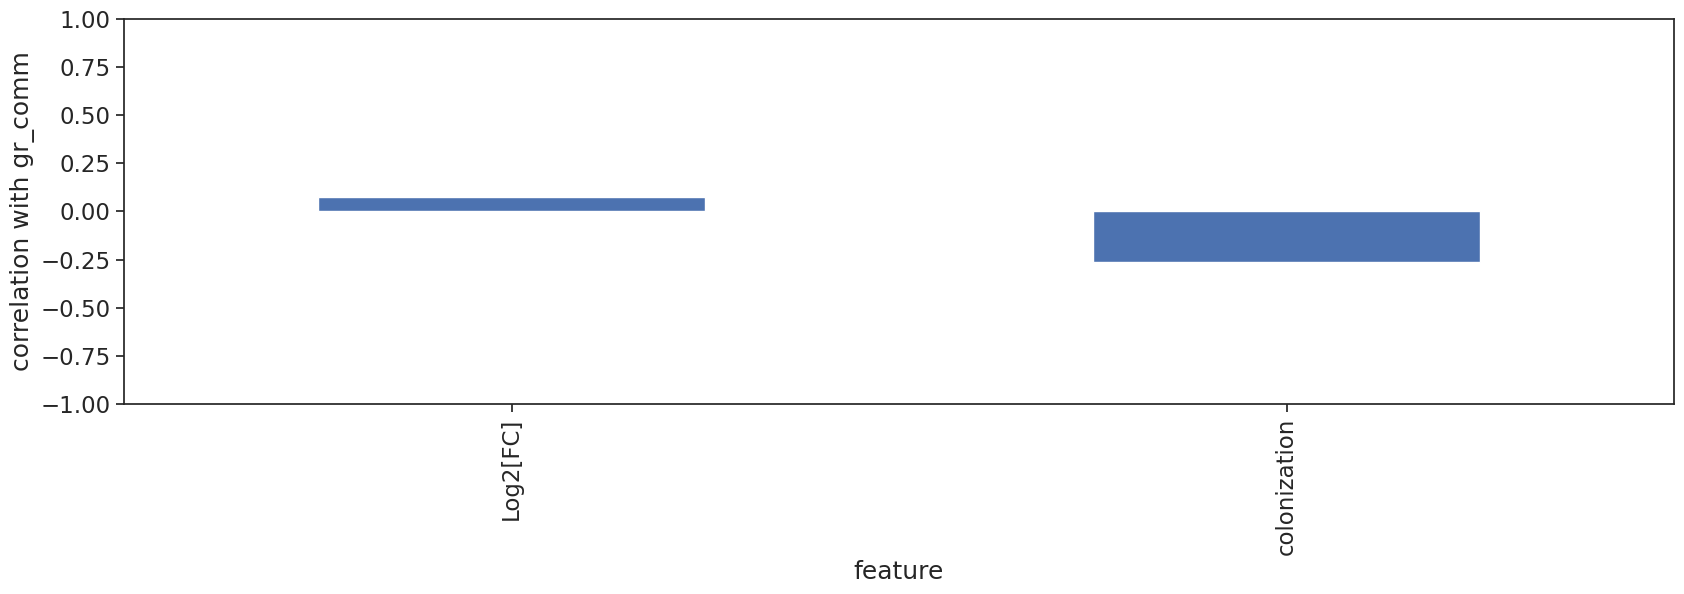

In [ ]:
%matplotlib inline
label_correlations.plot(kind="bar", xlabel="feature", ylabel="correlation with gr_comm", ylim=(-1,1))
plt.show()

## Machine learning

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
data_raw_all

,strain,colonization,exp,Log2[FC],interaction,gr1,gr2,gr_comm,gyd,mro1,...,mip1,mip2,mip_c1,mip_c2,bss1,bss2,pc1,pc2,pc_comm,fs
L145->L15,L15,2.606555e+07,Experiment 1,-0.811022,weak_negative,65.365,47.823,94.249,0.268370,64.706,...,1,6,0,3,23.529,78.000,0.72094,0.98538,0.83267,0.00000
L145->L154,L154,2.006572e+07,Experiment 2,-2.337404,negative,51.341,47.823,79.785,0.068522,73.333,...,0,5,0,3,28.889,74.000,0.77702,0.83417,0.80458,0.00000
L145->L164,L164,9.904762e+06,Experiment 2,-1.781047,negative,58.247,47.823,87.065,0.178962,79.070,...,0,4,0,4,30.233,70.000,0.74738,0.91027,0.82082,0.00000
L145->L179,L179,3.414800e+08,Experiment 1,0.611786,weak_positive,48.357,47.823,75.233,0.011043,75.556,...,0,5,0,4,33.333,76.000,0.77789,0.78657,0.78220,0.00000
L145->L202,L202,1.430846e+08,Experiment 1,0.114414,neutral,49.226,47.823,68.400,0.028501,95.833,...,1,0,1,0,33.333,34.000,0.69475,0.71513,0.70479,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L34->L257,L257,3.633593e+08,Experiment 1,-0.232018,weak_negative,45.215,54.871,58.092,-0.213557,92.105,...,1,1,0,0,68.421,70.213,0.64239,0.52936,0.58042,0.70211
L8->L145,L145,2.095671e+08,Experiment 2,-1.145950,negative,48.135,44.903,68.806,0.067144,64.000,...,7,0,3,0,72.000,31.707,0.71937,0.76616,0.74203,0.00000
L8->L154,L154,6.281776e+07,Experiment 2,-0.690964,weak_negative,77.067,44.903,93.076,0.417351,80.000,...,5,2,3,1,66.667,73.171,0.90646,1.03640,0.96709,0.69180
L8->L164,L164,6.343203e+06,Experiment 2,-2.423958,negative,63.018,44.903,89.698,0.287458,83.721,...,4,2,1,1,65.116,68.293,0.76999,0.99881,0.86960,0.78190


In [ ]:
cols_for_train_int = ["gr1", "gr2", "gr_comm", "gyd", "mro1", "mro2", "cip", "mip1", "mip2", "mip_c1", "mip_c2", "bss1", "bss2", "pc1", "pc2", "pc_comm", "fs"]
cols_for_train_pc = ["gr1", "gr2", "gr_comm", "gyd", "mro1", "mro2", "cip", "mip1", "mip2", "mip_c1", "mip_c2", "bss1", "bss2", "pc2", "pc_comm", "fs"]

In [ ]:
X = data_raw_all[cols_for_train_pc]
y = data_raw_all["pc1"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [ ]:
X_exp = data_raw_all[cols_for_train_int]
y_exp = data_raw_all["Log2[FC]"]

X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(X_exp, y_exp, random_state=42, test_size=0.3)

In [ ]:
steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LinearRegression())
]

pipeline = Pipeline(steps)

pipeline.fit(X_train, y_train)

print('Training score: {}'.format(pipeline.score(X_train, y_train)))
print('Test score: {}'.format(pipeline.score(X_test, y_test)))

Training score: 1.0
Test score: 0.7909118009951046


In [ ]:
steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Ridge(alpha=0.5, fit_intercept=True))
]

ridge_pipe = Pipeline(steps)
ridge_pipe.fit(X_train, y_train)

print('Training Score: {}'.format(ridge_pipe.score(X_train, y_train)))
print('Test Score: {}'.format(ridge_pipe.score(X_test, y_test)))

Training Score: 0.9998327938115344
Test Score: 0.7746263557115596


In [ ]:
steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Lasso(alpha=0.01, fit_intercept=True))
]

lasso_pipe = Pipeline(steps)

lasso_pipe.fit(X_train, y_train)

print('Training score: {}'.format(lasso_pipe.score(X_train, y_train)))
print('Test score: {}'.format(lasso_pipe.score(X_test, y_test)))

Training score: 0.9633694201399021
Test score: 0.8373335670017332


In [ ]:
elascv_reg = ElasticNetCV(alphas=np.logspace(-4, 1, 10), l1_ratio=np.linspace(0, 1, 10), cv=5, random_state=42)
elascv_reg.fit(X_train, y_train)
# Best parameters and estimator
print(f"Best alpha: {elascv_reg.alpha_}")
print(f"Best l1_ratio: {elascv_reg.l1_ratio_}")
print(f"intercept: {elascv_reg.intercept_}")

steps = [
    ('scalar', StandardScaler()),
    ('model', ElasticNet(alpha=elascv_reg.alpha_, l1_ratio=elascv_reg.l1_ratio_))
]

elastic_pipe = Pipeline(steps)

elastic_pipe.fit(X_train, y_train)

print('Training score: {}'.format(elastic_pipe.score(X_train, y_train)))
print('Test score: {}'.format(elastic_pipe.score(X_test, y_test)))

Best alpha: 0.0001
Best l1_ratio: 0.0
intercept: 0.6946816902876152
Training score: 0.9986688790618505
Test score: 0.9870105118762483


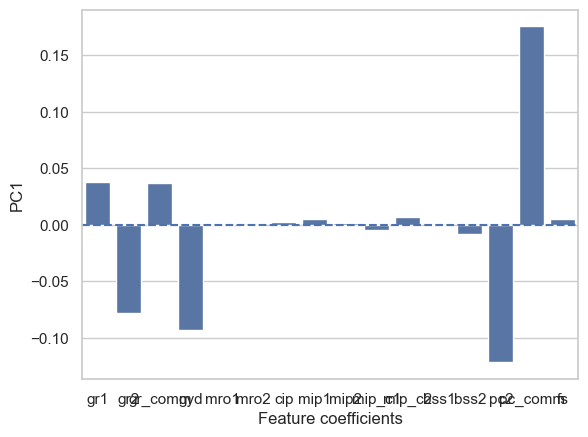

In [ ]:
features = elastic_pipe.feature_names_in_
coef = elastic_pipe.named_steps["model"].coef_
sns.barplot(x=features, y=coef, color="b")
plt.axhline(y=0.0, ls="--")
plt.xlabel("Feature coefficients")
plt.ylabel("PC1")
plt.savefig("ElasticNet_featureCoeffs.jpg")

In [ ]:
elascv_reg = ElasticNetCV(cv=5, random_state=42)
elascv_reg.fit(X_train_exp, y_train_exp)

elascv_reg.alpha_, elascv_reg.intercept_

(15.914746690553264, -0.9277320338769941)

In [ ]:
steps = [
    ('scalar', StandardScaler()),
    ('model', ElasticNet(alpha=0.01, l1_ratio=0.5))
]

elastic_pipe = Pipeline(steps)

elastic_pipe.fit(X_train_exp, y_train_exp)

print('Training score: {}'.format(elastic_pipe.score(X_train_exp, y_train_exp)))
print('Test score: {}'.format(elastic_pipe.score(X_test_exp, y_test_exp)))

Training score: 0.6127767830964035
Test score: -0.24280663094755495


Text(0, 0.5, 'Log2[FC]')

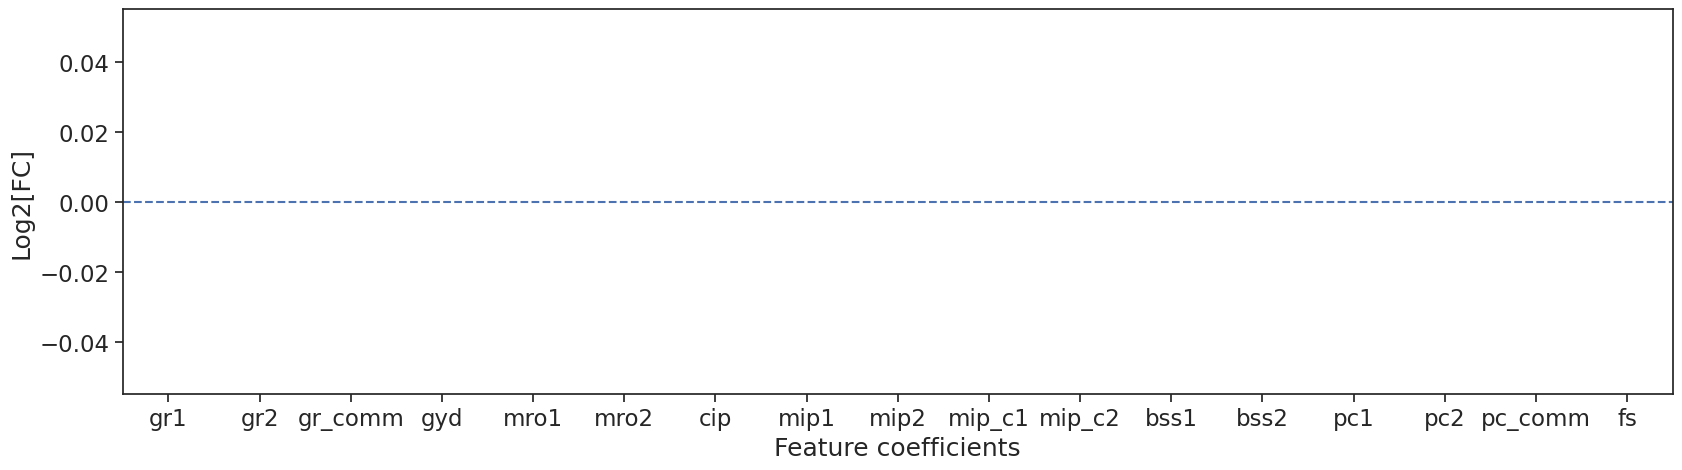

In [ ]:
features = elastic_pipe.feature_names_in_
coef = elastic_pipe.named_steps["model"].coef_
sns.barplot(x=features, y=coef, color="b")
plt.axhline(y=0.0, ls="--")
plt.xlabel("Feature coefficients")
plt.ylabel("Log2[FC]")